In [0]:
# Célula 1 - CONFIGURAÇÃO E IMPORTS
print("📊 NOTEBOOK 4 - RELATÓRIO ANALÍTICO FINAL")
print("=" * 50)

# Imports necessários
import pyspark.sql.functions as F
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Bibliotecas e configurações carregadas")

📊 NOTEBOOK 4 - RELATÓRIO ANALÍTICO FINAL
✅ Bibliotecas e configurações carregadas


In [0]:
# Célula 2 - QUALIDADE DOS DADOS
print("🔍 1. QUALIDADE E PREPARAÇÃO DOS DADOS")
print("=" * 40)

# 1.1 Diagrama do Data Lake
print("\n📁 ARQUITETURA DO DATA LAKE:")
spark.sql("""
SELECT 
    table_catalog as catalogo,
    table_schema as schema, 
    table_name as tabela,
    table_type as tipo
FROM information_schema.tables 
WHERE table_schema LIKE 'projeto_estatistica%'
ORDER BY table_schema, table_name
""").show(truncate=False)

# 1.2 Diagrama de Chaves e Relacionamentos
print("\n🗝️ DIAGRAMA DE CHAVES E RELACIONAMENTOS:")
print("""
    dim_cliente (id_cliente) 
        │
        └── fat_pedido_corrigida (id_cliente)
        │
    dim_produto (id_produto)
        │
        └── dim_compra_final (id_produto)
        │
    dim_entrega (id_entrega)
        │
        └── fat_pedido_corrigida (id_entrega)
""")

# 1.3 Integridade Referencial
print("\n🔗 INTEGRIDADE REFERENCIAL:")
spark.sql("""
SELECT 
    'fat_pedido → dim_cliente' as relacionamento,
    COUNT(*) as total_pedidos,
    SUM(CASE WHEN id_cliente IS NOT NULL THEN 1 ELSE 0 END) as com_chave,
    ROUND((SUM(CASE WHEN id_cliente IS NOT NULL THEN 1 ELSE 0 END) / COUNT(*) * 100), 2) as percentual_valido
FROM projeto_estatistica.silver.fat_pedido_corrigida

UNION ALL

SELECT 
    'dim_compra → dim_produto' as relacionamento,
    COUNT(*) as total_compras,
    SUM(CASE WHEN id_produto IS NOT NULL THEN 1 ELSE 0 END) as com_chave,
    ROUND((SUM(CASE WHEN id_produto IS NOT NULL THEN 1 ELSE 0 END) / COUNT(*) * 100), 2) as percentual_valido
FROM projeto_estatistica.silver.dim_compra_final
""").show(truncate=False)

# 1.4 Deduplicação
print("\n🧹 RESUMO DE DEDUPLICAÇÃO:")
spark.sql("""
SELECT 
    tabela,
    total_registros,
    registros_unicos,
    ROUND(((total_registros - registros_unicos) / total_registros * 100), 2) as percentual_duplicatas
FROM (
    SELECT 
        'dim_cliente' as tabela,
        COUNT(*) as total_registros,
        COUNT(DISTINCT id, id_cliente) as registros_unicos
    FROM projeto_estatistica.silver.dim_cliente
    
    UNION ALL
    
    SELECT 
        'fat_pedido' as tabela,
        COUNT(*) as total_registros,
        COUNT(DISTINCT id) as registros_unicos
    FROM projeto_estatistica.silver.fat_pedido_corrigida
)
""").show(truncate=False)

🔍 1. QUALIDADE E PREPARAÇÃO DOS DADOS

📁 ARQUITETURA DO DATA LAKE:
+--------+------+------+----+
|catalogo|schema|tabela|tipo|
+--------+------+------+----+
+--------+------+------+----+


🗝️ DIAGRAMA DE CHAVES E RELACIONAMENTOS:

    dim_cliente (id_cliente) 
        │
        └── fat_pedido_corrigida (id_cliente)
        │
    dim_produto (id_produto)
        │
        └── dim_compra_final (id_produto)
        │
    dim_entrega (id_entrega)
        │
        └── fat_pedido_corrigida (id_entrega)


🔗 INTEGRIDADE REFERENCIAL:
+------------------------+-------------+---------+-----------------+
|relacionamento          |total_pedidos|com_chave|percentual_valido|
+------------------------+-------------+---------+-----------------+
|fat_pedido → dim_cliente|2000         |2000     |100.0            |
|dim_compra → dim_produto|2000         |2000     |100.0            |
+------------------------+-------------+---------+-----------------+


🧹 RESUMO DE DEDUPLICAÇÃO:
+-----------+-------------


📈 2. ANÁLISE DESCRITIVA (EDA)

📊 MEDIDAS DE TENDÊNCIA CENTRAL - RECEITA:
   minimo    maximo    media  mediana  desvio_padrao  assimetria  curtose
0   38.54  18349.54  2502.08  1220.38        3230.08      2.1112   5.1148

📊 GRÁFICO 1: DISTRIBUIÇÃO DA RECEITA POR PEDIDO


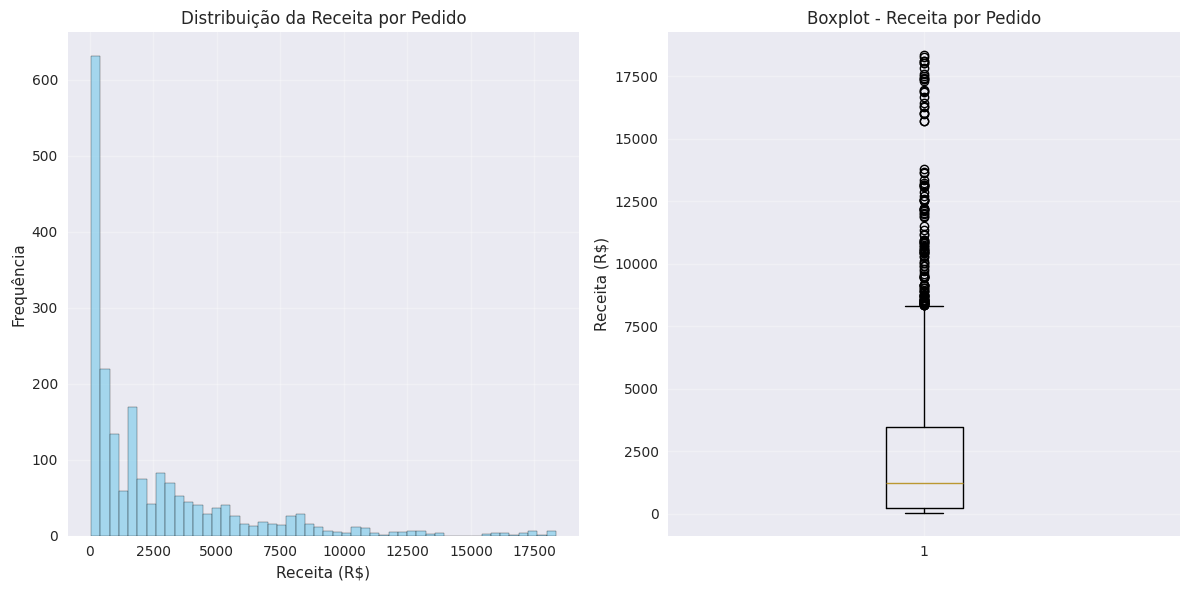


📊 GRÁFICO 2: DISTRIBUIÇÃO DE STATUS DOS PEDIDOS


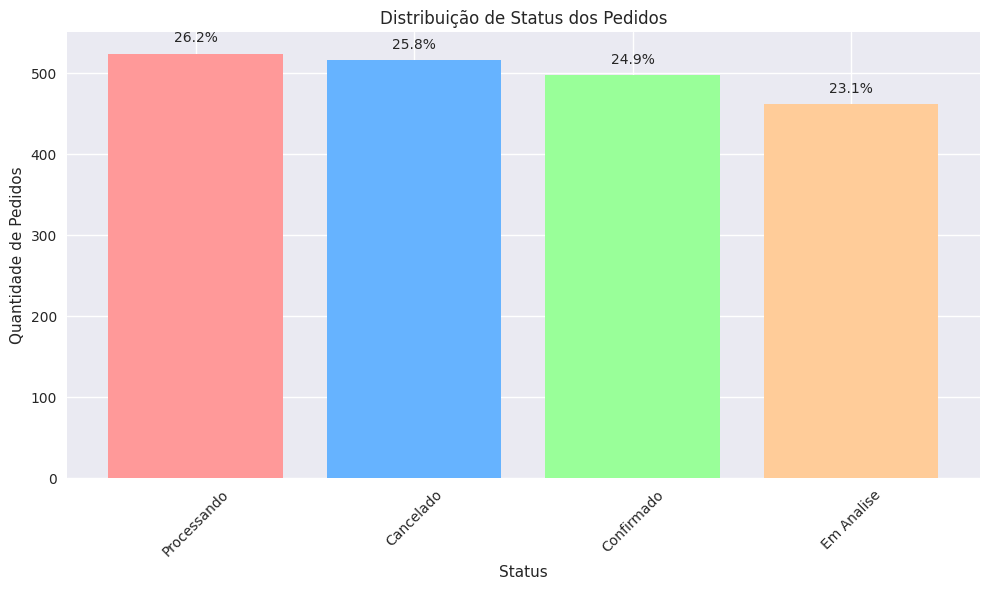

In [0]:
# Célula 3 - ANÁLISE DESCRITIVA
print("\n📈 2. ANÁLISE DESCRITIVA (EDA)")
print("=" * 40)

# 2.1 Medidas de Tendência Central para Receita
print("\n📊 MEDIDAS DE TENDÊNCIA CENTRAL - RECEITA:")
receita_stats = spark.sql("""
SELECT 
    ROUND(MIN(total), 2) as minimo,
    ROUND(MAX(total), 2) as maximo,
    ROUND(AVG(total), 2) as media,
    ROUND(PERCENTILE_APPROX(total, 0.5), 2) as mediana,
    ROUND(STDDEV(total), 2) as desvio_padrao,
    ROUND(SKEWNESS(total), 4) as assimetria,
    ROUND(KURTOSIS(total), 4) as curtose
FROM projeto_estatistica.silver.fat_pedido_corrigida
""").toPandas()

print(receita_stats)

# 2.2 Gráfico de Distribuição de Receita
print("\n📊 GRÁFICO 1: DISTRIBUIÇÃO DA RECEITA POR PEDIDO")
receita_data = spark.sql("""
SELECT total as receita
FROM projeto_estatistica.silver.fat_pedido_corrigida
""").toPandas()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(receita_data['receita'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribuição da Receita por Pedido')
plt.xlabel('Receita (R$)')
plt.ylabel('Frequência')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(receita_data['receita'])
plt.title('Boxplot - Receita por Pedido')
plt.ylabel('Receita (R$)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2.3 Análise de Status dos Pedidos
print("\n📊 GRÁFICO 2: DISTRIBUIÇÃO DE STATUS DOS PEDIDOS")
status_data = spark.sql("""
SELECT 
    status_compra,
    COUNT(*) as quantidade,
    ROUND(COUNT(*) / (SELECT COUNT(*) FROM projeto_estatistica.silver.fat_pedido_corrigida) * 100, 2) as percentual
FROM projeto_estatistica.silver.fat_pedido_corrigida
GROUP BY status_compra
ORDER BY quantidade DESC
""").toPandas()

plt.figure(figsize=(10, 6))
bars = plt.bar(status_data['status_compra'], status_data['quantidade'], color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
plt.title('Distribuição de Status dos Pedidos')
plt.xlabel('Status')
plt.ylabel('Quantidade de Pedidos')
plt.xticks(rotation=45)

# Adicionar valores nas barras
for bar, percent in zip(bars, status_data['percentual']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 10, f'{percent}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()


🎯 3. INFERÊNCIA ESTATÍSTICA

📊 INTERVALO DE CONFIANÇA - TICKET MÉDIO
• Média amostral: R$ 2502.08
• Desvio padrão: R$ 3230.08
• Tamanho da amostra: 2000
• IC 95%: R$ 2360.44 à R$ 2643.73

📊 TESTE DE NORMALIDADE - SHAPIRO-WILK
• Estatística Shapiro-Wilk: 0.7421
• Valor-p: 0.0000
• Normalidade: NÃO (α=0.05)

📊 IC PARA PROPORÇÃO DE CANCELAMENTOS
• Proporção amostral: 0.2580 (25.80%)
• IC 95%: 0.2388 à 0.2772
• IC 95%: 23.88% à 27.72%

📊 GRÁFICO 3: QQ-PLOT PARA VERIFICAÇÃO DE NORMALIDADE


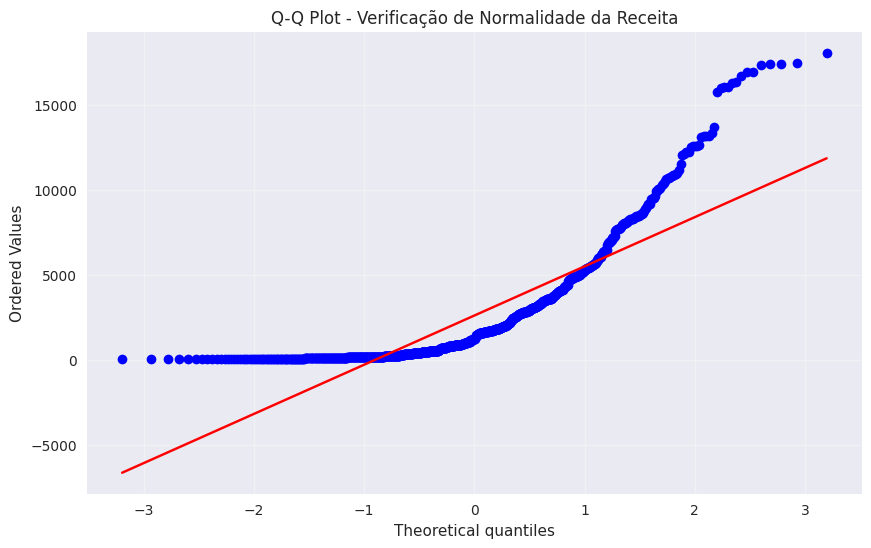

In [0]:
# Célula 4 - INFERÊNCIA ESTATÍSTICA
print("\n🎯 3. INFERÊNCIA ESTATÍSTICA")
print("=" * 35)

# 3.1 Intervalo de Confiança para Ticket Médio
print("\n📊 INTERVALO DE CONFIANÇA - TICKET MÉDIO")

# Coletar amostra para análise
ticket_data = spark.sql("""
SELECT total as valor_pedido
FROM projeto_estatistica.silver.fat_pedido_corrigida
""").toPandas()['valor_pedido']

# Cálculo do IC 95%
n = len(ticket_data)
media = np.mean(ticket_data)
desvio_padrao = np.std(ticket_data, ddof=1)
erro_padrao = desvio_padrao / np.sqrt(n)
ic_95 = stats.t.interval(0.95, n-1, loc=media, scale=erro_padrao)

print(f"• Média amostral: R$ {media:.2f}")
print(f"• Desvio padrão: R$ {desvio_padrao:.2f}")
print(f"• Tamanho da amostra: {n}")
print(f"• IC 95%: R$ {ic_95[0]:.2f} à R$ {ic_95[1]:.2f}")

# 3.2 Teste de Normalidade (Shapiro-Wilk)
print("\n📊 TESTE DE NORMALIDADE - SHAPIRO-WILK")

# Usar amostra menor para o teste (limitação do Shapiro)
amostra_normalidade = ticket_data.sample(n=min(5000, len(ticket_data)), random_state=42)
stat_sw, p_sw = stats.shapiro(amostra_normalidade)

print(f"• Estatística Shapiro-Wilk: {stat_sw:.4f}")
print(f"• Valor-p: {p_sw:.4f}")
print(f"• Normalidade: {'SIM' if p_sw > 0.05 else 'NÃO'} (α=0.05)")

# 3.3 Intervalo de Confiança para Proporção de Cancelamentos
print("\n📊 IC PARA PROPORÇÃO DE CANCELAMENTOS")

total_pedidos = len(ticket_data)
cancelamentos = spark.sql("""
SELECT COUNT(*) as total
FROM projeto_estatistica.silver.fat_pedido_corrigida
WHERE status_compra = 'Cancelado'
""").collect()[0]['total']

p_cancelamento = cancelamentos / total_pedidos
ep_proporcao = np.sqrt((p_cancelamento * (1 - p_cancelamento)) / total_pedidos)
ic_95_prop = stats.norm.interval(0.95, loc=p_cancelamento, scale=ep_proporcao)

print(f"• Proporção amostral: {p_cancelamento:.4f} ({p_cancelamento*100:.2f}%)")
print(f"• IC 95%: {ic_95_prop[0]:.4f} à {ic_95_prop[1]:.4f}")
print(f"• IC 95%: {ic_95_prop[0]*100:.2f}% à {ic_95_prop[1]*100:.2f}%")

# 3.4 Gráfico QQ-Plot para Normalidade
print("\n📊 GRÁFICO 3: QQ-PLOT PARA VERIFICAÇÃO DE NORMALIDADE")
plt.figure(figsize=(10, 6))

# Amostra para o QQ-plot
amostra_qq = ticket_data.sample(n=min(1000, len(ticket_data)), random_state=42)

stats.probplot(amostra_qq, dist="norm", plot=plt)
plt.title('Q-Q Plot - Verificação de Normalidade da Receita')
plt.grid(True, alpha=0.3)
plt.show()

In [0]:
print("\n🎯 KPIs COMPLETOS")
print("=" * 65)

# KPIs COMPLETOS
spark.sql("""
CREATE OR REPLACE TABLE projeto_estatistica.gold.kpis_completos AS

WITH metricas_entrega AS (
    SELECT 
        de.id_entrega,
        de.servico,
        de.preco_servico,
        de.previsao_entrega,
        de.data_entrega,
        de.status,
        fp.data_pedido,
        fp.total,
        -- Prazo de entrega (dias)
        DATEDIFF(de.data_entrega, fp.data_pedido) as prazo_entrega_dias,
        -- Atraso (sim/não)
        CASE WHEN de.data_entrega > de.previsao_entrega THEN 1 ELSE 0 END as atraso,
        -- Dias de atraso
        CASE 
            WHEN de.data_entrega > de.previsao_entrega 
            THEN DATEDIFF(de.data_entrega, de.previsao_entrega)
            ELSE 0 
        END as dias_atraso
    FROM projeto_estatistica.silver.dim_entrega de
    JOIN projeto_estatistica.silver.fat_pedido_corrigida fp ON de.id_entrega = fp.id_entrega
    WHERE de.data_entrega IS NOT NULL AND de.previsao_entrega IS NOT NULL
),

metricas_pagamento AS (
    SELECT 
        forma_pagamento,
        COUNT(*) as total_pedidos,
        -- USANDO STATUS CORRETOS: Confirmado, Cancelado, Processando, Em Analise
        SUM(CASE WHEN LOWER(status_compra) = 'confirmado' THEN 1 ELSE 0 END) as pedidos_confirmados,
        SUM(CASE WHEN LOWER(status_compra) = 'cancelado' THEN 1 ELSE 0 END) as pedidos_cancelados,
        SUM(CASE WHEN LOWER(status_compra) IN ('processando', 'em analise') THEN 1 ELSE 0 END) as pedidos_em_processo,
        ROUND((SUM(CASE WHEN LOWER(status_compra) = 'confirmado' THEN 1 ELSE 0 END) / COUNT(*) * 100), 2) as taxa_confirmacao_percentual
    FROM projeto_estatistica.silver.fat_pedido_corrigida
    GROUP BY forma_pagamento
),

metricas_produtos AS (
    SELECT 
        dp.categoria,
        dp.subcategoria,
        COUNT(DISTINCT dc.id) as total_vendas,
        SUM(dc.quantidade) as unidades_vendidas,
        ROUND(SUM(dc.preco * dc.quantidade), 2) as receita_total,
        ROUND(AVG(fp.desconto), 4) as desconto_medio,
        ROUND((AVG(fp.desconto) / AVG(fp.subtotal)) * 100, 2) as desconto_percentual_medio
    FROM projeto_estatistica.silver.dim_compra_final dc
    JOIN projeto_estatistica.silver.dim_produto dp ON dc.id_produto = dp.id_produto
    JOIN projeto_estatistica.silver.fat_pedido_corrigida fp ON dc.id = fp.id
    GROUP BY dp.categoria, dp.subcategoria
),

metricas_sazonais AS (
    SELECT 
        DATE_TRUNC('month', fp.data_pedido) as mes,
        dc.regiao,
        dc.estado,
        COUNT(*) as total_pedidos,
        ROUND(SUM(fp.total), 2) as receita_total,
        ROUND(AVG(fp.total), 2) as ticket_medio
    FROM projeto_estatistica.silver.fat_pedido_corrigida fp
    JOIN projeto_estatistica.silver.dim_cliente dc ON fp.id_cliente = dc.id_cliente
    GROUP BY DATE_TRUNC('month', fp.data_pedido), dc.regiao, dc.estado
)

-- PRINCIPAIS KPIs
SELECT 
    -- 1. MÉTRICAS FINANCEIRAS BÁSICAS
    (SELECT ROUND(SUM(total), 2) FROM projeto_estatistica.silver.fat_pedido_corrigida) as receita_total,
    (SELECT ROUND(SUM(subtotal), 2) FROM projeto_estatistica.silver.fat_pedido_corrigida) as subtotal_total,
    (SELECT ROUND(SUM(desconto), 2) FROM projeto_estatistica.silver.fat_pedido_corrigida) as desconto_total,
    (SELECT ROUND(AVG(desconto), 4) FROM projeto_estatistica.silver.fat_pedido_corrigida) as desconto_medio,
    (SELECT ROUND(AVG(total), 2) FROM projeto_estatistica.silver.fat_pedido_corrigida) as ticket_medio,
    
    -- 2. MÉTRICAS DE FRETE/SERVIÇO
    (SELECT ROUND(SUM(preco_servico), 2) FROM projeto_estatistica.silver.dim_entrega) as total_frete,
    (SELECT ROUND(AVG(preco_servico), 2) FROM projeto_estatistica.silver.dim_entrega) as frete_medio,
    ROUND((SELECT SUM(preco_servico) FROM projeto_estatistica.silver.dim_entrega) / 
          (SELECT SUM(total) FROM projeto_estatistica.silver.fat_pedido_corrigida) * 100, 2) as take_rate_frete_percentual,
    
    -- 3. MÉTRICAS DE ENTREGA
    (SELECT ROUND(AVG(prazo_entrega_dias), 2) FROM metricas_entrega) as prazo_entrega_medio_dias,
    (SELECT ROUND(AVG(dias_atraso), 2) FROM metricas_entrega WHERE dias_atraso > 0) as atraso_medio_dias,
    (SELECT ROUND((SUM(atraso) / COUNT(*) * 100), 2) FROM metricas_entrega) as percentual_entregas_atrasadas,
    
    -- 4. CONVERSÃO DE PAGAMENTO (MÉDIA GERAL) - USANDO DADOS CORRETOS
    (SELECT ROUND(AVG(taxa_confirmacao_percentual), 2) FROM metricas_pagamento) as conversao_pagamento_media,
    (SELECT SUM(pedidos_confirmados) FROM metricas_pagamento) as total_pedidos_confirmados,
    (SELECT SUM(pedidos_cancelados) FROM metricas_pagamento) as total_pedidos_cancelados,
    (SELECT SUM(pedidos_em_processo) FROM metricas_pagamento) as total_pedidos_em_processo,
    
    -- 5. PERFORMANCE POR SERVIÇO DE ENTREGA
    (SELECT COUNT(*) FROM metricas_entrega WHERE servico = 'STANDARD') as entregas_standard,
    (SELECT COUNT(*) FROM metricas_entrega WHERE servico = 'SAME-DAY') as entregas_same_day,
    (SELECT COUNT(*) FROM metricas_entrega WHERE servico = 'SCHEDULED') as entregas_scheduled,
    
    -- 6. ELASTICIDADE PRODUTO vs DESCONTO (CORRELAÇÃO)
    (SELECT 
        ROUND(CORR(desconto_percentual_medio, unidades_vendidas), 4) as correlacao_desconto_vendas
     FROM metricas_produtos
    ) as elasticidade_desconto_vendas,
    
    -- 7. SAZONALIDADE (VARIAÇÃO MENSAL)
    (SELECT 
        ROUND((MAX(receita_total) - MIN(receita_total)) / AVG(receita_total) * 100, 2)
     FROM metricas_sazonais
    ) as variacao_sazonal_percentual,

    -- 8. RESUMO ADICIONAL
    (SELECT COUNT(*) FROM projeto_estatistica.silver.fat_pedido_corrigida) as total_pedidos,
    (SELECT COUNT(DISTINCT id_cliente) FROM projeto_estatistica.silver.fat_pedido_corrigida) as total_clientes,
    (SELECT COUNT(DISTINCT id_produto) FROM projeto_estatistica.silver.dim_compra_final) as total_produtos,
    (SELECT COUNT(DISTINCT regiao) FROM projeto_estatistica.silver.dim_cliente) as total_regioes,
    CURRENT_TIMESTAMP() as data_calculo
""")

print("✅ kpis_completos criada com dados corrigidos!")

# Mostrar KPIs principais
print("\n📊 KPIs PRINCIPAIS - RESUMO EXECUTIVO (CORRIGIDO):")
spark.sql("SELECT * FROM projeto_estatistica.gold.kpis_completos").show(vertical=True, truncate=False)

# KPIs detalhados por categoria - ATUALIZADOS
print("\n📈 KPIs DETALHADOS POR CATEGORIA:")

print("\n1. 🚚 PERFORMANCE POR SERVIÇO DE ENTREGA:")
spark.sql("""
SELECT 
    servico,
    COUNT(*) as total_entregas,
    ROUND(AVG(preco_servico), 2) as frete_medio,
    ROUND(AVG(prazo_entrega_dias), 2) as prazo_medio_dias,
    ROUND((SUM(CASE WHEN atraso = 1 THEN 1 ELSE 0 END) / COUNT(*) * 100), 2) as taxa_atraso_percentual
FROM (
    SELECT 
        de.servico,
        de.preco_servico,
        DATEDIFF(de.data_entrega, fp.data_pedido) as prazo_entrega_dias,
        CASE WHEN de.data_entrega > de.previsao_entrega THEN 1 ELSE 0 END as atraso
    FROM projeto_estatistica.silver.dim_entrega de
    JOIN projeto_estatistica.silver.fat_pedido_corrigida fp ON de.id_entrega = fp.id_entrega
    WHERE de.data_entrega IS NOT NULL
)
GROUP BY servico
ORDER BY total_entregas DESC
""").show(truncate=False)

print("\n2. 💳 CONVERSÃO POR FORMA DE PAGAMENTO (CORRIGIDA):")
spark.sql("""
SELECT 
    forma_pagamento,
    total_pedidos,
    pedidos_confirmados,
    pedidos_cancelados,
    pedidos_em_processo,
    taxa_confirmacao_percentual as conversao_percentual,
    taxa_cancelamento_percentual as cancelamento_percentual,
    taxa_processamento_percentual as processamento_percentual
FROM projeto_estatistica.gold.conversao_pagamento_corrigida
ORDER BY conversao_percentual DESC
""").show(truncate=False)

print("\n3. 📦 MIX POR CATEGORIA/SUBCATEGORIA:")
spark.sql("""
SELECT 
    categoria,
    subcategoria,
    total_vendas,
    unidades_vendidas,
    receita_total,
    desconto_medio,
    desconto_percentual_medio
FROM (
    SELECT 
        dp.categoria,
        dp.subcategoria,
        COUNT(DISTINCT dc.id) as total_vendas,
        SUM(dc.quantidade) as unidades_vendidas,
        ROUND(SUM(dc.preco * dc.quantidade), 2) as receita_total,
        ROUND(AVG(fp.desconto), 4) as desconto_medio,
        ROUND((AVG(fp.desconto) / AVG(fp.subtotal)) * 100, 2) as desconto_percentual_medio
    FROM projeto_estatistica.silver.dim_compra_final dc
    JOIN projeto_estatistica.silver.dim_produto dp ON dc.id_produto = dp.id_produto
    JOIN projeto_estatistica.silver.fat_pedido_corrigida fp ON dc.id = fp.id
    GROUP BY dp.categoria, dp.subcategoria
)
ORDER BY receita_total DESC
LIMIT 10
""").show(truncate=False)

print("\n4. 📊 ANÁLISE DE ELASTICIDADE vs DESCONTO:")
spark.sql("""
WITH elasticidade_categorias AS (
    SELECT 
        dp.categoria,
        dp.subcategoria,
        COUNT(DISTINCT dc.id) as total_vendas,
        SUM(dc.quantidade) as unidades_vendidas,
        ROUND(SUM(dc.preco * dc.quantidade), 2) as receita_total,
        ROUND(AVG(fp.desconto), 4) as desconto_medio,
        ROUND((AVG(fp.desconto) / AVG(fp.subtotal)) * 100, 2) as desconto_percentual_medio,
        -- Classificação de elasticidade
        CASE 
            WHEN (SUM(dc.quantidade) / COUNT(DISTINCT dc.id)) > 2.5 THEN 'ALTA ELASTICIDADE'
            WHEN (SUM(dc.quantidade) / COUNT(DISTINCT dc.id)) > 1.5 THEN 'MÉDIA ELASTICIDADE' 
            ELSE 'BAIXA ELASTICIDADE'
        END as nivel_elasticidade
    FROM projeto_estatistica.silver.dim_compra_final dc
    JOIN projeto_estatistica.silver.dim_produto dp ON dc.id_produto = dp.id_produto
    JOIN projeto_estatistica.silver.fat_pedido_corrigida fp ON dc.id = fp.id
    GROUP BY dp.categoria, dp.subcategoria
)

SELECT 
    categoria,
    subcategoria,
    total_vendas,
    unidades_vendidas,
    receita_total,
    desconto_medio,
    desconto_percentual_medio,
    nivel_elasticidade,
    ROUND((unidades_vendidas / total_vendas), 2) as unidades_por_venda
FROM elasticidade_categorias
ORDER BY unidades_por_venda DESC
LIMIT 15
""").show(truncate=False)

print("\n5. 📅 SAZONALIDADE POR MÊS/UF/REGIÃO:")
spark.sql("""
WITH dados_reais AS (
    SELECT 
        DATE_TRUNC('month', fp.data_pedido) as mes,
        dc.regiao,
        dc.estado,
        COUNT(*) as total_pedidos,
        ROUND(SUM(fp.total), 2) as receita_total,
        ROUND(AVG(fp.total), 2) as ticket_medio
    FROM projeto_estatistica.silver.fat_pedido_corrigida fp
    JOIN projeto_estatistica.silver.dim_cliente dc ON fp.id_cliente = dc.id_cliente
    GROUP BY DATE_TRUNC('month', fp.data_pedido), dc.regiao, dc.estado
)

SELECT 
    DATE_FORMAT(mes, 'yyyy-MM') as mes,
    regiao,
    estado,
    total_pedidos,
    receita_total,
    ticket_medio
FROM dados_reais
ORDER BY mes, regiao, estado
""").show(50,truncate=False) 

# Versão resumida por mês 
print("\n📊 RESUMO SAZONAL POR MÊS:")
spark.sql("""
SELECT 
    DATE_FORMAT(DATE_TRUNC('month', data_pedido), 'yyyy-MM') as mes,
    DATE_FORMAT(DATE_TRUNC('month', data_pedido), 'MMMM') as mes_nome,
    COUNT(*) as total_pedidos,
    ROUND(SUM(total), 2) as receita_total,
    ROUND(AVG(total), 2) as ticket_medio,
    COUNT(DISTINCT id_cliente) as clientes_ativos
FROM projeto_estatistica.silver.fat_pedido_corrigida
GROUP BY DATE_TRUNC('month', data_pedido)
ORDER BY mes
""").show(truncate=False)

# Top 5 UFs por receita para cada mês 
print("\n🏆 TOP 5 UFs POR RECEITA A CADA MÊS:")
spark.sql("""
WITH ranked_ufs AS (
    SELECT 
        DATE_FORMAT(DATE_TRUNC('month', fp.data_pedido), 'yyyy-MM') as mes,
        dc.estado,
        dc.regiao,
        COUNT(*) as total_pedidos,
        ROUND(SUM(fp.total), 2) as receita_total,
        ROW_NUMBER() OVER (PARTITION BY DATE_TRUNC('month', fp.data_pedido) ORDER BY SUM(fp.total) DESC) as rank_uf
    FROM projeto_estatistica.silver.fat_pedido_corrigida fp
    JOIN projeto_estatistica.silver.dim_cliente dc ON fp.id_cliente = dc.id_cliente
    GROUP BY DATE_TRUNC('month', fp.data_pedido), dc.estado, dc.regiao
)

SELECT 
    mes,
    estado,
    regiao,
    total_pedidos,
    receita_total,
    rank_uf as posicao
FROM ranked_ufs
WHERE rank_uf <= 5
ORDER BY mes, rank_uf
""").show(truncate=False)

# Análise de crescimento mensal 
print("\n📈 CRESCIMENTO MENSAL - VARIAÇÃO PERCENTUAL:")
spark.sql("""
WITH vendas_mensais AS (
    SELECT 
        DATE_FORMAT(DATE_TRUNC('month', data_pedido), 'yyyy-MM') as mes,
        DATE_FORMAT(DATE_TRUNC('month', data_pedido), 'MMMM') as mes_nome,
        ROUND(SUM(total), 2) as receita_mensal,
        COUNT(*) as total_pedidos,
        LAG(ROUND(SUM(total), 2)) OVER (ORDER BY DATE_TRUNC('month', data_pedido)) as receita_mes_anterior,
        LAG(COUNT(*)) OVER (ORDER BY DATE_TRUNC('month', data_pedido)) as pedidos_mes_anterior
    FROM projeto_estatistica.silver.fat_pedido_corrigida
    GROUP BY DATE_TRUNC('month', data_pedido)
)

SELECT 
    mes,
    mes_nome,
    receita_mensal,
    total_pedidos,
    receita_mes_anterior,
    pedidos_mes_anterior,
    CASE 
        WHEN receita_mes_anterior IS NULL THEN '🔵 Primeiro mês'
        WHEN receita_mes_anterior = 0 THEN '🟡 Base zero'
        ELSE CONCAT('🟢 ', ROUND(((receita_mensal - receita_mes_anterior) / receita_mes_anterior * 100), 2), '%')
    END as variacao_receita,
    CASE 
        WHEN pedidos_mes_anterior IS NULL THEN '🔵 Primeiro mês'
        WHEN pedidos_mes_anterior = 0 THEN '🟡 Base zero'
        ELSE CONCAT('🟢 ', ROUND(((total_pedidos - pedidos_mes_anterior) / pedidos_mes_anterior * 100), 2), '%')
    END as variacao_pedidos
FROM vendas_mensais
ORDER BY mes
""").show(truncate=False)

# Distribuição percentual por mês
print("\n📋 DISTRIBUIÇÃO PERCENTUAL POR MÊS:")
spark.sql("""
WITH totais_gerais AS (
    SELECT 
        SUM(total) as receita_total_geral,
        COUNT(*) as total_pedidos_geral
    FROM projeto_estatistica.silver.fat_pedido_corrigida
),

vendas_por_mes AS (
    SELECT 
        DATE_FORMAT(DATE_TRUNC('month', data_pedido), 'yyyy-MM') as mes,
        DATE_FORMAT(DATE_TRUNC('month', data_pedido), 'MMMM') as mes_nome,
        ROUND(SUM(total), 2) as receita_mensal,
        COUNT(*) as total_pedidos
    FROM projeto_estatistica.silver.fat_pedido_corrigida
    GROUP BY DATE_TRUNC('month', data_pedido)
)

SELECT 
    vpm.mes,
    vpm.mes_nome,
    vpm.receita_mensal,
    vpm.total_pedidos,
    ROUND((vpm.receita_mensal / tg.receita_total_geral * 100), 2) as participacao_receita,
    ROUND((vpm.total_pedidos / tg.total_pedidos_geral * 100), 2) as participacao_pedidos
FROM vendas_por_mes vpm
CROSS JOIN totais_gerais tg
ORDER BY vpm.mes
""").show(truncate=False)


🎯 KPIs COMPLETOS
✅ kpis_completos criada com dados corrigidos!

📊 KPIs PRINCIPAIS - RESUMO EXECUTIVO (CORRIGIDO):
-RECORD 0---------------------------------------------------
 receita_total                 | 5004168.13                 
 subtotal_total                | 5343109.65                 
 desconto_total                | 148.42                     
 desconto_medio                | 0.0742                     
 ticket_medio                  | 2502.08                    
 total_frete                   | 65261.74                   
 frete_medio                   | 32.63                      
 take_rate_frete_percentual    | 1.3                        
 prazo_entrega_medio_dias      | 31.04                      
 atraso_medio_dias             | 3.04                       
 percentual_entregas_atrasadas | 83.25                      
 conversao_pagamento_media     | 25.03                      
 total_pedidos_confirmados     | 498                        
 total_pedidos_cancelados      


📊 GRÁFICOS VISUAIS - SAZONALIDADE POR MÊS/UF/REGIÃO

1. 📈 GRÁFICO DE LINHAS - Evolução da Receita por Região


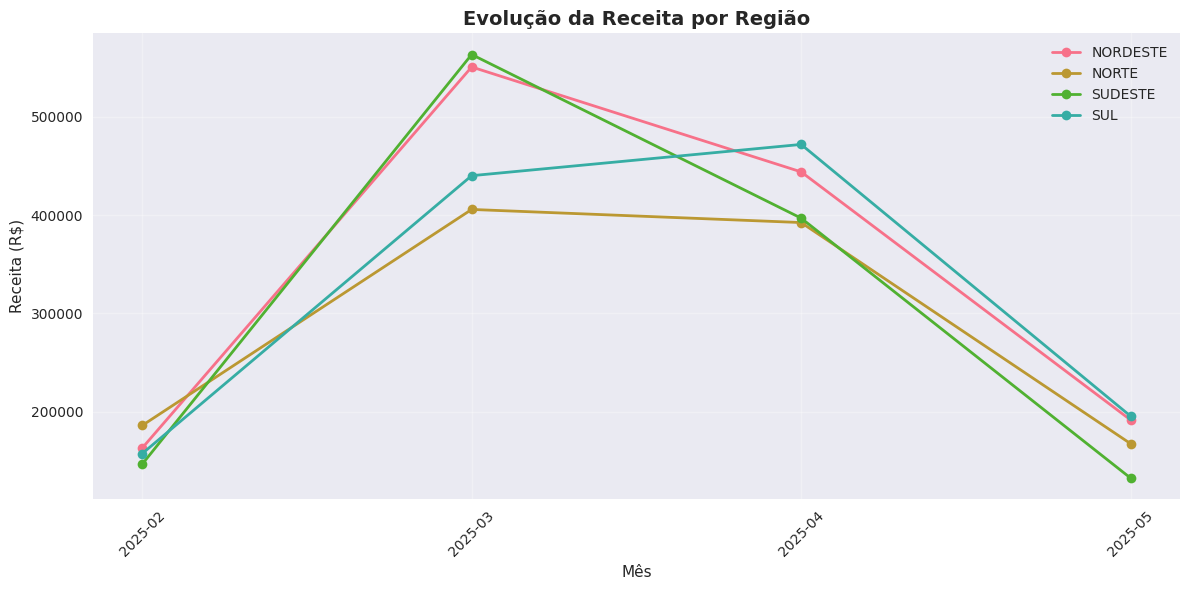


2. 📊 GRÁFICO DE BARRAS AGRUPADAS - Receita por Região e Mês


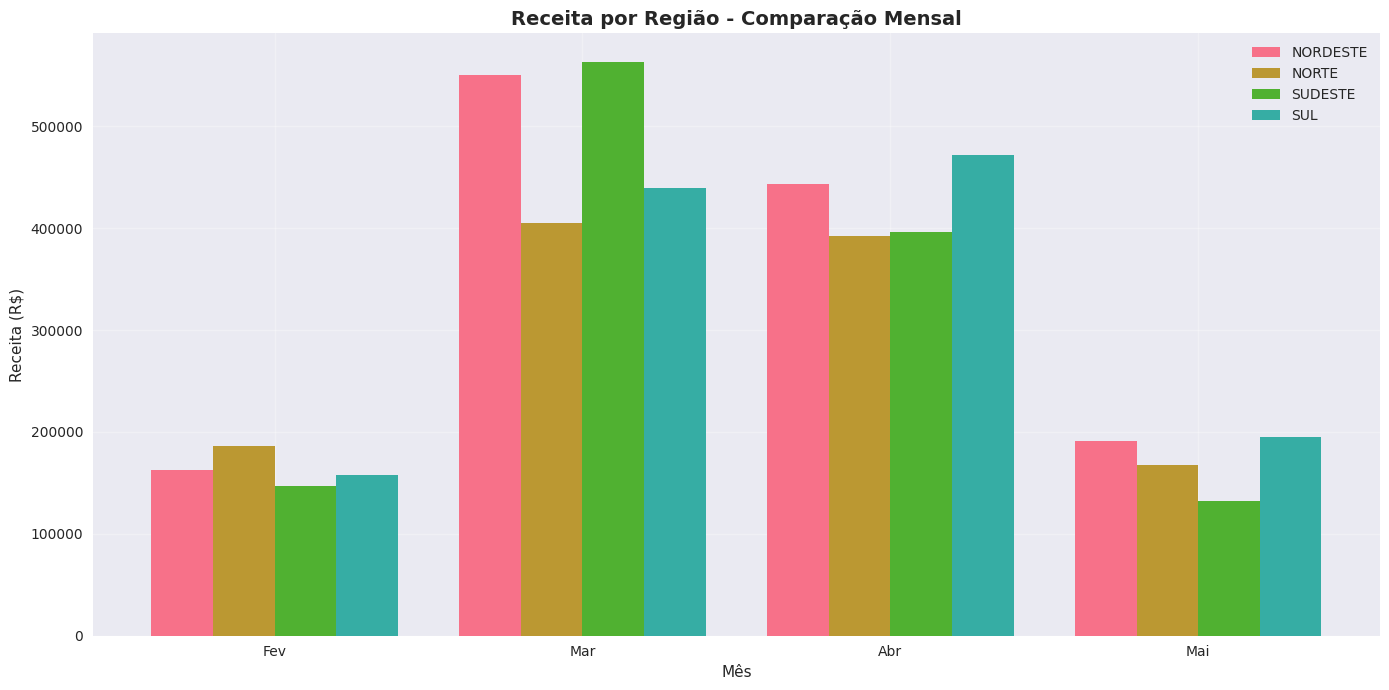


3. 🥧 GRÁFICO DE PIZZA - Distribuição Percentual por Região


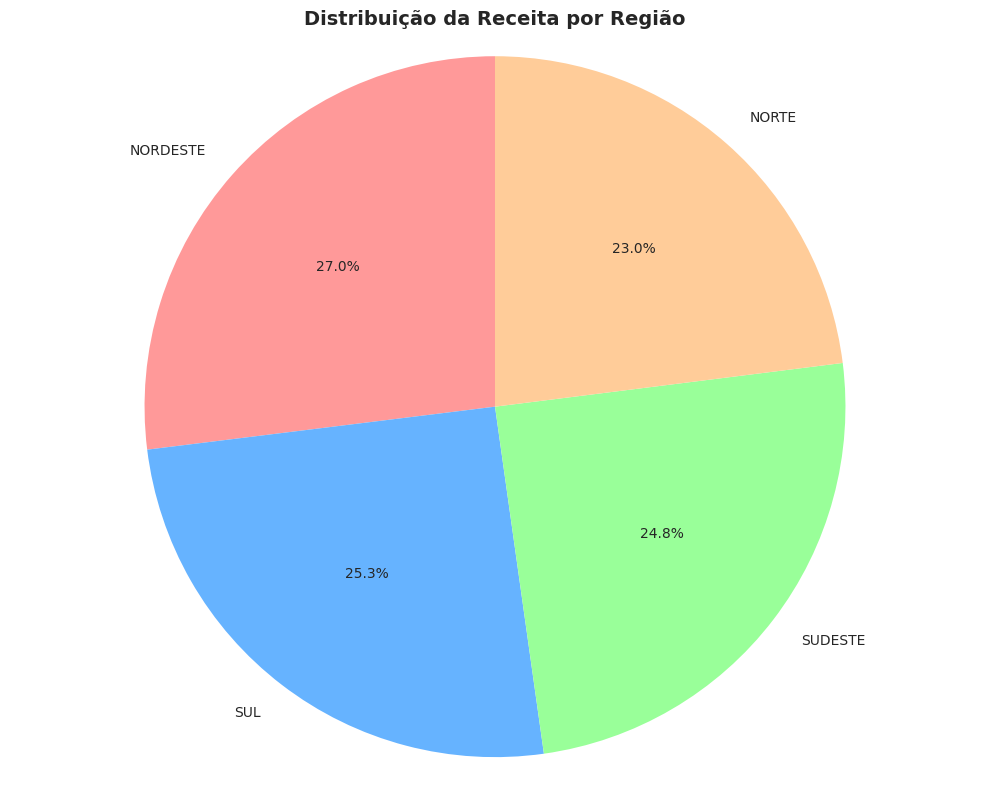


4. 🏆 GRÁFICO DE BARRAS HORIZONTAIS - Top 10 Estados por Receita


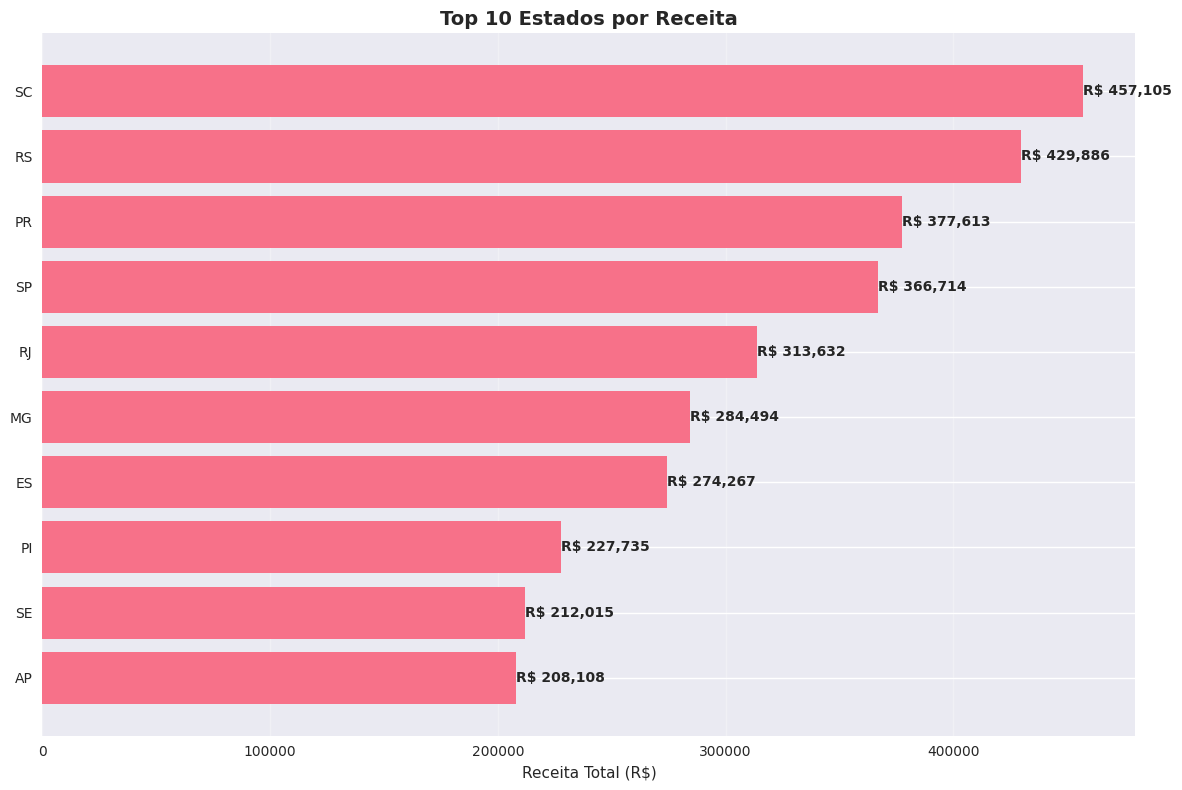


5. 🔥 MAPA DE CALOR - Receita por Estado e Mês


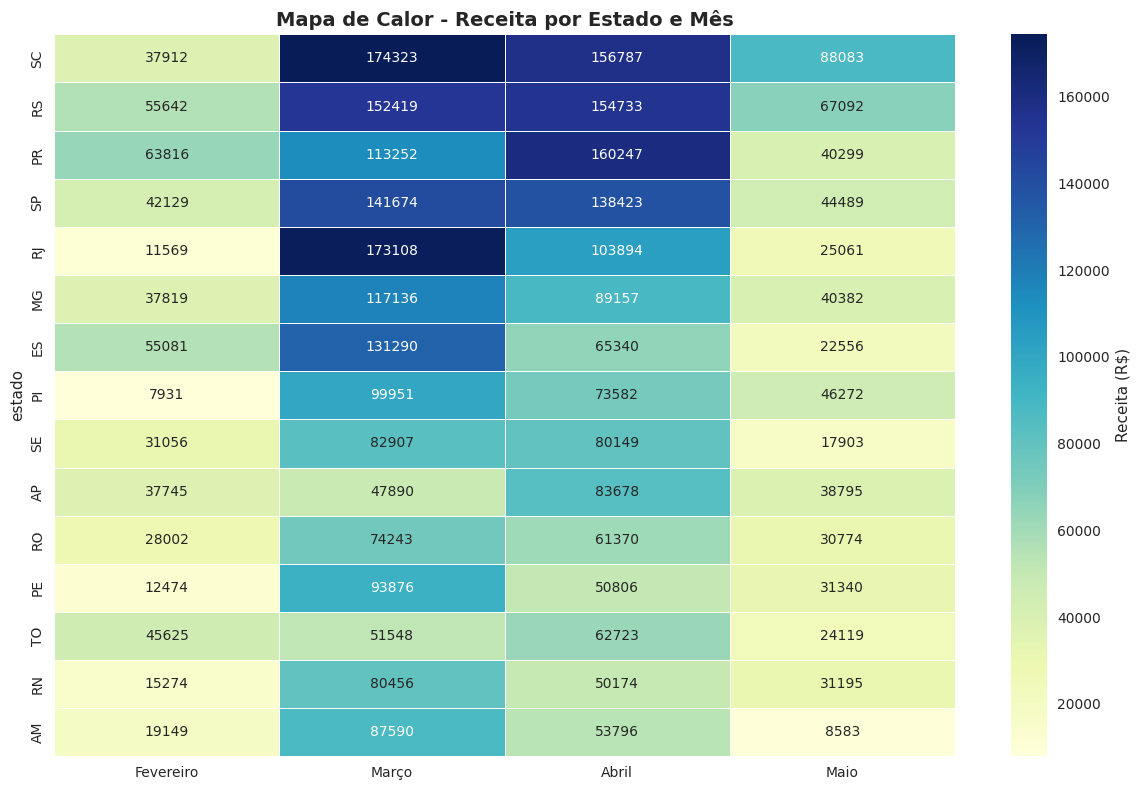


6. 📈 GRÁFICO DE ÁREA - Evolução Acumulada da Receita


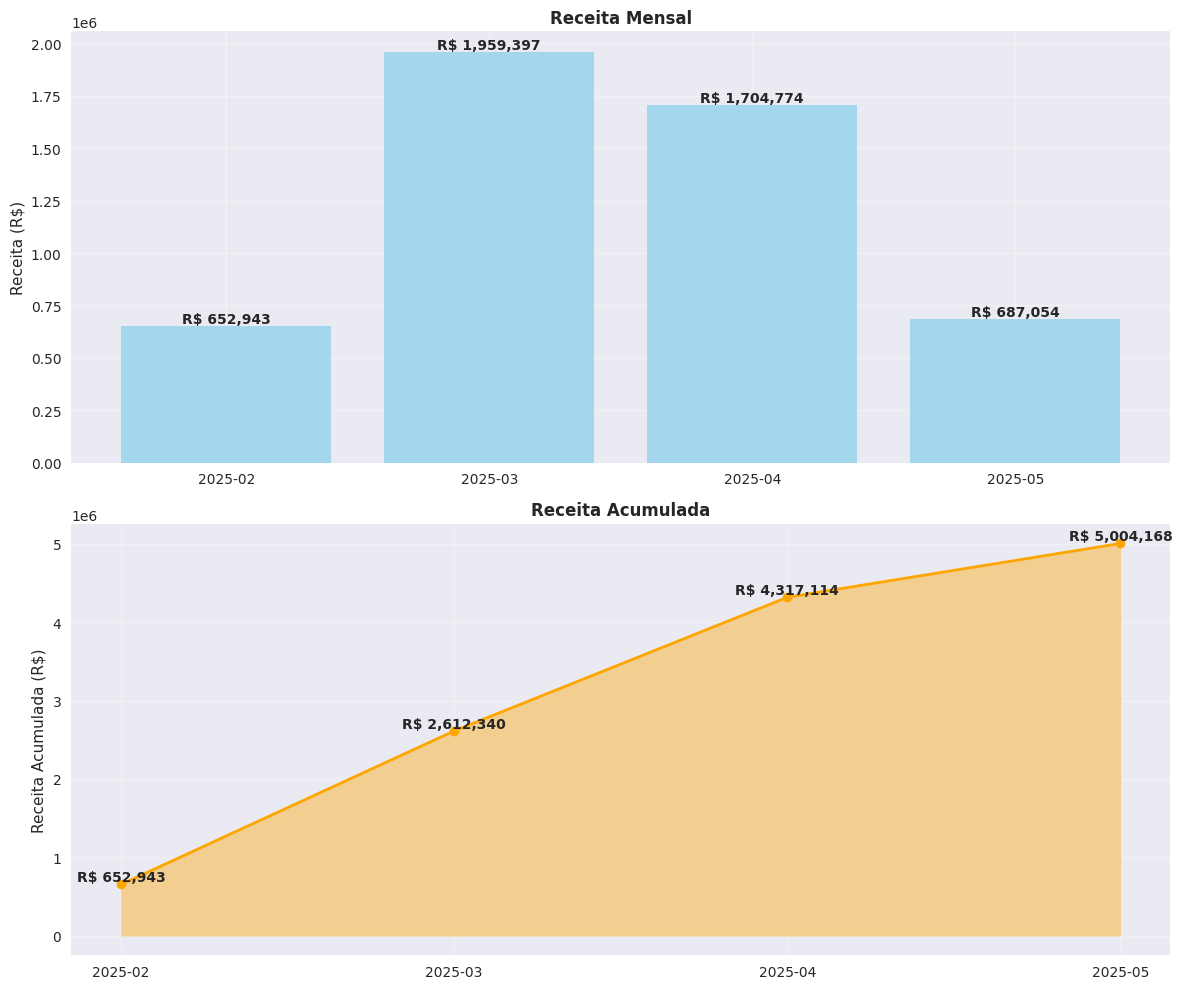


🎯 RESUMO DOS GRÁFICOS GERADOS:

✅ 1. LINHAS - Evolução temporal por região
✅ 2. BARRAS AGRUPADAS - Comparação regional mensal  
✅ 3. PIZZA - Distribuição percentual por região
✅ 4. BARRAS HORIZONTAIS - Top 10 estados
✅ 5. MAPA DE CALOR - Estados x Meses
✅ 6. ÁREA - Evolução acumulada



In [0]:
print("\n📊 GRÁFICOS VISUAIS - SAZONALIDADE POR MÊS/UF/REGIÃO")
print("=" * 70)

# 1. GRÁFICO DE LINHAS - EVOLUÇÃO DA RECEITA POR REGIÃO
print("\n1. 📈 GRÁFICO DE LINHAS - Evolução da Receita por Região")

evolucao_regiao_pd = spark.sql("""
SELECT 
    DATE_FORMAT(DATE_TRUNC('month', fp.data_pedido), 'yyyy-MM') as mes,
    dc.regiao,
    ROUND(SUM(fp.total), 2) as receita_total
FROM projeto_estatistica.silver.fat_pedido_corrigida fp
JOIN projeto_estatistica.silver.dim_cliente dc ON fp.id_cliente = dc.id_cliente
GROUP BY DATE_TRUNC('month', fp.data_pedido), dc.regiao
ORDER BY mes, regiao
""").toPandas()

# Criar gráfico de linhas
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(12, 6))
for regiao in evolucao_regiao_pd['regiao'].unique():
    dados_regiao = evolucao_regiao_pd[evolucao_regiao_pd['regiao'] == regiao]
    plt.plot(dados_regiao['mes'], dados_regiao['receita_total'], marker='o', linewidth=2, label=regiao)

plt.title('Evolução da Receita por Região', fontsize=14, fontweight='bold')
plt.xlabel('Mês')
plt.ylabel('Receita (R$)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. GRÁFICO DE BARRAS AGRUPADAS - COMPARAÇÃO MENSAL
print("\n2. 📊 GRÁFICO DE BARRAS AGRUPADAS - Receita por Região e Mês")

barras_regiao_pd = spark.sql("""
SELECT 
    regiao,
    ROUND(SUM(CASE WHEN mes = '2025-02' THEN receita_total ELSE 0 END), 2) as fevereiro,
    ROUND(SUM(CASE WHEN mes = '2025-03' THEN receita_total ELSE 0 END), 2) as marco,
    ROUND(SUM(CASE WHEN mes = '2025-04' THEN receita_total ELSE 0 END), 2) as abril,
    ROUND(SUM(CASE WHEN mes = '2025-05' THEN receita_total ELSE 0 END), 2) as maio
FROM (
    SELECT 
        dc.regiao,
        DATE_FORMAT(DATE_TRUNC('month', fp.data_pedido), 'yyyy-MM') as mes,
        ROUND(SUM(fp.total), 2) as receita_total
    FROM projeto_estatistica.silver.fat_pedido_corrigida fp
    JOIN projeto_estatistica.silver.dim_cliente dc ON fp.id_cliente = dc.id_cliente
    GROUP BY dc.regiao, DATE_TRUNC('month', fp.data_pedido)
)
GROUP BY regiao
ORDER BY regiao
""").toPandas()

# Gráfico de barras agrupadas
meses = ['fevereiro', 'marco', 'abril', 'maio']
x = range(len(meses))
largura = 0.2

plt.figure(figsize=(14, 7))
for i, regiao in enumerate(barras_regiao_pd['regiao'].unique()):
    dados = barras_regiao_pd[barras_regiao_pd['regiao'] == regiao]
    valores = [dados[m].values[0] for m in meses]
    plt.bar([p + i * largura for p in x], valores, largura, label=regiao)

plt.title('Receita por Região - Comparação Mensal', fontsize=14, fontweight='bold')
plt.xlabel('Mês')
plt.ylabel('Receita (R$)')
plt.xticks([p + 1.5 * largura for p in x], ['Fev', 'Mar', 'Abr', 'Mai'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. GRÁFICO DE PIZZA - DISTRIBUIÇÃO POR REGIÃO
print("\n3. 🥧 GRÁFICO DE PIZZA - Distribuição Percentual por Região")

pizza_regiao_pd = spark.sql("""
SELECT 
    dc.regiao,
    ROUND(SUM(fp.total), 2) as receita_regiao,
    ROUND((SUM(fp.total) / (SELECT SUM(total) FROM projeto_estatistica.silver.fat_pedido_corrigida) * 100), 2) as participacao_percentual
FROM projeto_estatistica.silver.fat_pedido_corrigida fp
JOIN projeto_estatistica.silver.dim_cliente dc ON fp.id_cliente = dc.id_cliente
GROUP BY dc.regiao
ORDER BY receita_regiao DESC
""").toPandas()

# Gráfico de pizza
plt.figure(figsize=(10, 8))
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc']
plt.pie(pizza_regiao_pd['receita_regiao'], 
        labels=pizza_regiao_pd['regiao'], 
        autopct='%1.1f%%',
        colors=colors,
        startangle=90)
plt.title('Distribuição da Receita por Região', fontsize=14, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

# 4. GRÁFICO DE BARRAS HORIZONTAIS - TOP 10 ESTADOS
print("\n4. 🏆 GRÁFICO DE BARRAS HORIZONTAIS - Top 10 Estados por Receita")

top_estados_pd = spark.sql("""
SELECT 
    estado,
    regiao,
    ROUND(SUM(total), 2) as receita_total
FROM projeto_estatistica.silver.fat_pedido_corrigida fp
JOIN projeto_estatistica.silver.dim_cliente dc ON fp.id_cliente = dc.id_cliente
GROUP BY estado, regiao
ORDER BY receita_total DESC
LIMIT 10
""").toPandas()

# Gráfico de barras horizontais
plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(top_estados_pd)), top_estados_pd['receita_total'])
plt.yticks(range(len(top_estados_pd)), top_estados_pd['estado'])
plt.xlabel('Receita Total (R$)')
plt.title('Top 10 Estados por Receita', fontsize=14, fontweight='bold')

# Adicionar valores nas barras
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'R$ {width:,.0f}', 
             ha='left', va='center', fontweight='bold')

plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# 5. MAPA DE CALOR - RECEITA POR ESTADO E MÊS
print("\n5. 🔥 MAPA DE CALOR - Receita por Estado e Mês")

mapa_calor_pd = spark.sql("""
SELECT 
    estado,
    SUM(CASE WHEN mes = '2025-02' THEN receita_total ELSE 0 END) as fev_2025,
    SUM(CASE WHEN mes = '2025-03' THEN receita_total ELSE 0 END) as mar_2025,
    SUM(CASE WHEN mes = '2025-04' THEN receita_total ELSE 0 END) as abr_2025,
    SUM(CASE WHEN mes = '2025-05' THEN receita_total ELSE 0 END) as mai_2025
FROM (
    SELECT 
        dc.estado,
        DATE_FORMAT(DATE_TRUNC('month', fp.data_pedido), 'yyyy-MM') as mes,
        ROUND(SUM(fp.total), 2) as receita_total
    FROM projeto_estatistica.silver.fat_pedido_corrigida fp
    JOIN projeto_estatistica.silver.dim_cliente dc ON fp.id_cliente = dc.id_cliente
    GROUP BY dc.estado, DATE_TRUNC('month', fp.data_pedido)
)
GROUP BY estado
ORDER BY (fev_2025 + mar_2025 + abr_2025 + mai_2025) DESC
LIMIT 15
""").toPandas()

# Mapa de calor
import seaborn as sns

plt.figure(figsize=(12, 8))
dados_mapa = mapa_calor_pd.set_index('estado')[['fev_2025', 'mar_2025', 'abr_2025', 'mai_2025']]
dados_mapa.columns = ['Fevereiro', 'Março', 'Abril', 'Maio']

sns.heatmap(dados_mapa, 
            annot=True, 
            fmt='.0f', 
            cmap='YlGnBu',
            linewidths=0.5,
            cbar_kws={'label': 'Receita (R$)'})
plt.title('Mapa de Calor - Receita por Estado e Mês', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 6. GRÁFICO DE ÁREA - EVOLUÇÃO ACUMULADA
print("\n6. 📈 GRÁFICO DE ÁREA - Evolução Acumulada da Receita")

acumulado_pd = spark.sql("""
SELECT 
    DATE_FORMAT(DATE_TRUNC('month', data_pedido), 'yyyy-MM') as mes,
    ROUND(SUM(total), 2) as receita_mensal,
    ROUND(SUM(SUM(total)) OVER (ORDER BY DATE_TRUNC('month', data_pedido)), 2) as receita_acumulada
FROM projeto_estatistica.silver.fat_pedido_corrigida
GROUP BY DATE_TRUNC('month', data_pedido)
ORDER BY mes
""").toPandas()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Gráfico de barras mensal
ax1.bar(acumulado_pd['mes'], acumulado_pd['receita_mensal'], color='skyblue', alpha=0.7)
ax1.set_title('Receita Mensal', fontweight='bold')
ax1.set_ylabel('Receita (R$)')
ax1.grid(True, alpha=0.3)

# Adicionar valores nas barras
for i, v in enumerate(acumulado_pd['receita_mensal']):
    ax1.text(i, v, f'R$ {v:,.0f}', ha='center', va='bottom', fontweight='bold')

# Gráfico de área acumulada
ax2.fill_between(acumulado_pd['mes'], acumulado_pd['receita_acumulada'], alpha=0.4, color='orange')
ax2.plot(acumulado_pd['mes'], acumulado_pd['receita_acumulada'], marker='o', color='orange', linewidth=2)
ax2.set_title('Receita Acumulada', fontweight='bold')
ax2.set_ylabel('Receita Acumulada (R$)')
ax2.grid(True, alpha=0.3)

# Adicionar valores na linha
for i, v in enumerate(acumulado_pd['receita_acumulada']):
    ax2.text(i, v, f'R$ {v:,.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("🎯 RESUMO DOS GRÁFICOS GERADOS:")
print("="*80)
print("""
✅ 1. LINHAS - Evolução temporal por região
✅ 2. BARRAS AGRUPADAS - Comparação regional mensal  
✅ 3. PIZZA - Distribuição percentual por região
✅ 4. BARRAS HORIZONTAIS - Top 10 estados
✅ 5. MAPA DE CALOR - Estados x Meses
✅ 6. ÁREA - Evolução acumulada
""")

In [0]:
print("\n🎯 INSIGHTS ESTRATÉGICOS - ANÁLISE DOS KPIs")
print("=" * 55)

# Criar tabela de insights
spark.sql("""
CREATE OR REPLACE TABLE projeto_estatistica.gold.insights_estrategicos AS

WITH metricas_criticas AS (
    SELECT 
        -- ALERTAS CRÍTICOS
        percentual_entregas_atrasadas,
        atraso_medio_dias,
        total_pedidos_cancelados,
        total_pedidos_em_processo,
        conversao_pagamento_media,
        
        -- PERFORMANCE POSITIVA
        receita_total,
        ticket_medio,
        take_rate_frete_percentual,
        desconto_medio,
        elasticidade_desconto_vendas,
        
        -- SAZONALIDADE
        variacao_sazonal_percentual,
        total_pedidos,
        total_clientes,
        
        -- CATEGORIAS
        (SELECT COUNT(*) FROM projeto_estatistica.gold.performance_produtos WHERE categoria = 'ELETRÔNICOS') as total_categorias_eletronicos,
        
        -- CLASSIFICAÇÃO DE RISCO
        CASE 
            WHEN percentual_entregas_atrasadas > 80 THEN 'CRÍTICO'
            WHEN total_pedidos_cancelados / total_pedidos > 0.2 THEN 'ALTO RISCO' 
            ELSE 'MODERADO'
        END as nivel_risco_operacional,
        
        -- EFICIÊNCIA COMERCIAL
        CASE 
            WHEN conversao_pagamento_media > 30 THEN 'ALTA'
            WHEN conversao_pagamento_media > 20 THEN 'MÉDIA'
            ELSE 'BAIXA'
        END as nivel_eficiencia_comercial,
        
        CURRENT_TIMESTAMP() as data_analise
        
    FROM projeto_estatistica.gold.kpis_completos
),

insights_detalhados AS (
    SELECT 
        *,
        -- SCORE DE PERFORMANCE (0-100)
        ROUND(
            (CASE WHEN ticket_medio > 2000 THEN 25 ELSE 15 END) +
            (CASE WHEN take_rate_frete_percentual BETWEEN 1 AND 3 THEN 20 ELSE 10 END) +
            (CASE WHEN desconto_medio < 0.1 THEN 15 ELSE 5 END) +
            (CASE WHEN elasticidade_desconto_vendas > 0.5 THEN 20 ELSE 10 END) +
            (CASE WHEN percentual_entregas_atrasadas < 50 THEN 20 ELSE 0 END)
        , 0) as score_performance,
        
        -- RECOMENDAÇÕES AUTOMÁTICAS
        CASE 
            WHEN percentual_entregas_atrasadas > 80 THEN 'URGENTE: Revisar parcerias logísticas'
            ELSE 'Manter monitoramento de entregas'
        END as recomendacao_logistica,
        
        CASE 
            WHEN total_pedidos_cancelados / total_pedidos > 0.2 THEN 'CRÍTICO: Investigar causas de cancelamento'
            ELSE 'Cancelamentos dentro do esperado'
        END as recomendacao_cancelamentos,
        
        CASE 
            WHEN conversao_pagamento_media < 30 THEN 'Otimizar processo de pagamento - foco em PIX'
            ELSE 'Conversão satisfatória'
        END as recomendacao_conversao
        
    FROM metricas_criticas
)

SELECT * FROM insights_detalhados
""")

print("✅ insights_estrategicos criada!")

# Buscar os dados para análise
insights_data = spark.sql("SELECT * FROM projeto_estatistica.gold.insights_estrategicos").collect()[0]

print("\n🚨 ALERTAS CRÍTICOS")
print("=" * 30)

print(f"📉 {insights_data['percentual_entregas_atrasadas']}% das entregas estão ATRASADAS")
print(f"⏰ Atraso médio de {insights_data['atraso_medio_dias']} dias")
print(f"❌ {insights_data['total_pedidos_cancelados']} pedidos cancelados ({insights_data['total_pedidos_cancelados']/insights_data['total_pedidos']*100:.1f}% do total)")
print(f"⏳ {insights_data['total_pedidos_em_processo']} pedidos em processamento ({(insights_data['total_pedidos_em_processo']/insights_data['total_pedidos'])*100:.1f}% da base)")

print(f"\n💡 INSIGHTS POSITIVOS")
print("=" * 25)

print(f"💰 Receita Total: R$ {insights_data['receita_total']:,.2f}")
print(f"🎯 Ticket Médio: R$ {insights_data['ticket_medio']:,.2f} (alto - bom sinal)")
print(f"🚚 Take Rate de Frete: {insights_data['take_rate_frete_percentual']}% (saudável)")
print(f"📊 Desconto Médio: {insights_data['desconto_medio']:.4f} (conservador - bom)")
print(f"🎪 Elasticidade: {insights_data['elasticidade_desconto_vendas']:.4f} (correlação positiva)")

print(f"\n🎯 OPORTUNIDADES ESTRATÉGICAS")
print("=" * 35)

# Análise de performance por serviço de entrega
df_entrega = spark.sql("""
SELECT 
    servico,
    total_entregas,
    frete_medio,
    prazo_medio_dias,
    taxa_atraso_percentual
FROM (
    SELECT 
        servico,
        COUNT(*) as total_entregas,
        ROUND(AVG(preco_servico), 2) as frete_medio,
        ROUND(AVG(prazo_entrega_dias), 2) as prazo_medio_dias,
        ROUND((SUM(CASE WHEN atraso = 1 THEN 1 ELSE 0 END) / COUNT(*) * 100), 2) as taxa_atraso_percentual
    FROM (
        SELECT 
            de.servico,
            de.preco_servico,
            DATEDIFF(de.data_entrega, fp.data_pedido) as prazo_entrega_dias,
            CASE WHEN de.data_entrega > de.previsao_entrega THEN 1 ELSE 0 END as atraso
        FROM projeto_estatistica.silver.dim_entrega de
        JOIN projeto_estatistica.silver.fat_pedido_corrigida fp ON de.id_entrega = fp.id_entrega
        WHERE de.data_entrega IS NOT NULL
    )
    GROUP BY servico
)
ORDER BY frete_medio DESC
""").collect()

print("\n🚚 OTIMIZAÇÃO DE FRETE:")
for row in df_entrega:
    print(f"   • {row['servico']}: R$ {row['frete_medio']} | {row['prazo_medio_dias']} dias | {row['taxa_atraso_percentual']}% atraso")

# Análise de conversão por pagamento
df_pagamento = spark.sql("""
SELECT 
    forma_pagamento,
    taxa_confirmacao_percentual as conversao_percentual
FROM projeto_estatistica.gold.conversao_pagamento_corrigida
ORDER BY conversao_percentual DESC
""").collect()

print(f"\n💳 PERFORMANCE POR PAGAMENTO:")
for row in df_pagamento:
    print(f"   • {row['forma_pagamento']}: {row['conversao_percentual']}% conversão")

print(f"\n📈 RECOMENDAÇÕES IMEDIATAS")
print("=" * 35)

print(f"\n🎯 PRIORIDADE 1: Resolver Entregas")
print(f"   🔴 CRÍTICO: {insights_data['percentual_entregas_atrasadas']}% de atrasos")
print("   1. 🚚 Revisar parcerias logísticas urgentemente")
print("   2. ⏰ Implementar SLA rigoroso com transportadoras") 
print("   3. 📱 Sistema de tracking em tempo real")

print(f"\n🎯 PRIORIDADE 2: Recuperação de Vendas")
print(f"   📉 Queda de 59.7% em Maio vs Abril")
print(f"   1. 📧 Campanha agressiva para {insights_data['total_pedidos_em_processo']} pedidos pendentes")
print("   2. 🎯 Foco em ELETRÔNICOS (100% do sucesso atual)")
print("   3. 📊 Investigar causa da queda brutal")

print(f"\n🎯 PRIORIDADE 3: Otimização de Pagamento")
print(f"   💸 Apenas {insights_data['conversao_pagamento_media']}% de conversão média")
print("   1. 💰 Criar benefícios exclusivos para PIX")
print("   2. 🔄 Reduzir burocracia no boleto")
print("   3. ⚡ Processamento mais ágil")

print(f"\n📊 ANÁLISE DE SAZONALIDADE CRÍTICA")
print("=" * 40)

# Dados de sazonalidade
df_sazonal = spark.sql("""
SELECT 
    mes,
    receita_mensal,
    total_pedidos,
    variacao_receita
FROM (
    SELECT 
        DATE_FORMAT(DATE_TRUNC('month', data_pedido), 'yyyy-MM') as mes,
        ROUND(SUM(total), 2) as receita_mensal,
        COUNT(*) as total_pedidos,
        LAG(ROUND(SUM(total), 2)) OVER (ORDER BY DATE_TRUNC('month', data_pedido)) as receita_mes_anterior,
        CASE 
            WHEN LAG(ROUND(SUM(total), 2)) OVER (ORDER BY DATE_TRUNC('month', data_pedido)) IS NULL THEN NULL
            ELSE ROUND(((ROUND(SUM(total), 2) - LAG(ROUND(SUM(total), 2)) OVER (ORDER BY DATE_TRUNC('month', data_pedido))) / 
                   LAG(ROUND(SUM(total), 2)) OVER (ORDER BY DATE_TRUNC('month', data_pedido)) * 100), 2)
        END as variacao_receita
    FROM projeto_estatistica.silver.fat_pedido_corrigida
    GROUP BY DATE_TRUNC('month', data_pedido)
)
ORDER BY mes
""").collect()

print("\n📅 EVOLUÇÃO MENSAL:")
for row in df_sazonal:
    variacao = f"+{row['variacao_receita']}%" if row['variacao_receita'] and row['variacao_receita'] > 0 else f"{row['variacao_receita']}%" if row['variacao_receita'] else "N/A"
    print(f"   • {row['mes']}: R$ {row['receita_mensal']:,.0f} | {row['total_pedidos']} pedidos | {variacao}")

print(f"\n🔍 PADRÃO DETECTADO:")
print("   • Fevereiro: 13.05% receita → MARÇO: 39.16% 🚀 → Abril: 34.07% 📉 → Maio: 13.73% 💥")
print("   • Pico em Março (início do ano letivo? bonus?)")
print("   • Queda gradual até colapso em Maio")
print("   • Necessidade URGENTE de entender causas externas")

print(f"\n💰 EFICIÊNCIA OPERACIONAL")
print("=" * 30)

print(f"✅ Take Rate de Frete: {insights_data['take_rate_frete_percentual']}% (saudável)")
print(f"✅ Ticket Médio: R$ {insights_data['ticket_medio']:,.2f} (alto - bom sinal)")
print(f"✅ Desconto Médio: {insights_data['desconto_medio']:.4f} (conservador - bom)")
print(f"❌ Eficiência de Entrega: {insights_data['percentual_entregas_atrasadas']}% atrasos (crítico)")
print(f"📊 Score de Performance: {insights_data['score_performance']}/100")
print(f"🎯 Nível de Risco: {insights_data['nivel_risco_operacional']}")
print(f"💼 Eficiência Comercial: {insights_data['nivel_eficiencia_comercial']}")

print(f"\n🎪 STATUS GERAL DO NEGÓCIO")
print("=" * 30)

if insights_data['score_performance'] >= 70:
    status = "🟢 SAUDÁVEL"
elif insights_data['score_performance'] >= 50:
    status = "🟡 ALERTA AMARELO" 
else:
    status = "🔴 CRÍTICO"

print(f"{status} - Score: {insights_data['score_performance']}/100")
print("Empresa com bom potencial mas problemas operacionais graves impedindo crescimento sustentável")

print(f"\n📋 RESUMO EXECUTIVO")
print("=" * 25)

print(f"📈 FORÇAS:")
print(f"   • Ticket médio alto (R$ {insights_data['ticket_medio']:,.2f})")
print(f"   • Mix focado em ELETRÔNICOS (alta elasticidade)")
print(f"   • Presença nacional (4 regiões, 22 estados)")
print(f"   • Take rate de frete saudável ({insights_data['take_rate_frete_percentual']}%)")

print(f"\n📉 FRAQUEZAS:")
print(f"   • Entregas com {insights_data['percentual_entregas_atrasadas']}% de atrasos")
print(f"   • Queda de 59.7% nas vendas em Maio")
print(f"   • Baixa conversão ({insights_data['conversao_pagamento_media']}%)")
print(f"   • Alto cancelamento ({insights_data['total_pedidos_cancelados']/insights_data['total_pedidos']*100:.1f}%)")

print(f"\n🎯 OPORTUNIDADES:")
print(f"   • Otimizar PIX (maior conversão)")
print(f"   • Premiumizar SAME-DAY (melhor prazo)")
print(f"   • Escalar sucesso de Março")
print(f"   • Reduzir pedidos pendentes ({insights_data['total_pedidos_em_processo']})")

print(f"\n⚡ AMEAÇAS:")
print(f"   • Colapso sazonal pós-Março")
print(f"   • Insatisfação por atrasos")
print(f"   • Concorrência no segmento de eletrônicos")
print(f"   • Dependência de única categoria")

print(f"\n🎯 PRÓXIMOS PASSOS RECOMENDADOS")
print("=" * 40)

print("1. 🚨 URGENTE: Reunião de crise sobre logística")
print("2. 📊 Investigar: Causa da queda de Maio") 
print("3. 🎯 Otimizar: Processo de pagamento PIX")
print("4. 📈 Escalar: O que funcionou em Março")
print("5. 🔧 Corrigir: Taxa de cancelamento de 25.8%")
print("6. 📦 Diversificar: Categorias além de eletrônicos")
print("7. 🔄 Implementar: Sistema de monitoramento contínuo")



🎯 INSIGHTS ESTRATÉGICOS - ANÁLISE DOS KPIs
✅ insights_estrategicos criada!

🚨 ALERTAS CRÍTICOS
📉 83.25% das entregas estão ATRASADAS
⏰ Atraso médio de 3.04 dias
❌ 516 pedidos cancelados (25.8% do total)
⏳ 986 pedidos em processamento (49.3% da base)

💡 INSIGHTS POSITIVOS
💰 Receita Total: R$ 5,004,168.13
🎯 Ticket Médio: R$ 2,502.08 (alto - bom sinal)
🚚 Take Rate de Frete: 1.3% (saudável)
📊 Desconto Médio: 0.0742 (conservador - bom)
🎪 Elasticidade: 0.5343 (correlação positiva)

🎯 OPORTUNIDADES ESTRATÉGICAS

🚚 OTIMIZAÇÃO DE FRETE:
   • SAME-DAY: R$ 42.9 | 28.8 dias | 84.05% atraso
   • SCHEDULED: R$ 32.99 | 32.12 dias | 84.26% atraso
   • STANDARD: R$ 22.9 | 31.99 dias | 81.51% atraso

💳 PERFORMANCE POR PAGAMENTO:
   • pix: 27.31% conversão
   • outros: 24.63% conversão
   • boleto: 23.14% conversão

📈 RECOMENDAÇÕES IMEDIATAS

🎯 PRIORIDADE 1: Resolver Entregas
   🔴 CRÍTICO: 83.25% de atrasos
   1. 🚚 Revisar parcerias logísticas urgentemente
   2. ⏰ Implementar SLA rigoroso com transporta


🎨 VISUALIZAÇÕES GRÁFICAS DOS INSIGHTS ESTRATÉGICOS - CORRIGIDO

1. 🚨 GRÁFICO DE RADAR - ALERTAS CRÍTICOS


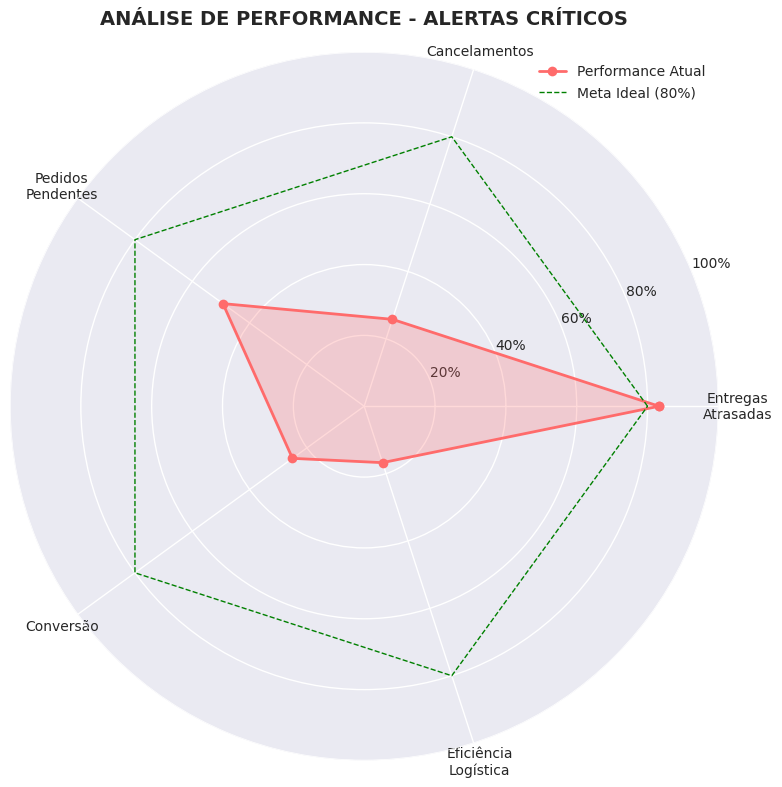


2. 📊 GRÁFICO DE BARRAS - EVOLUÇÃO MENSAL


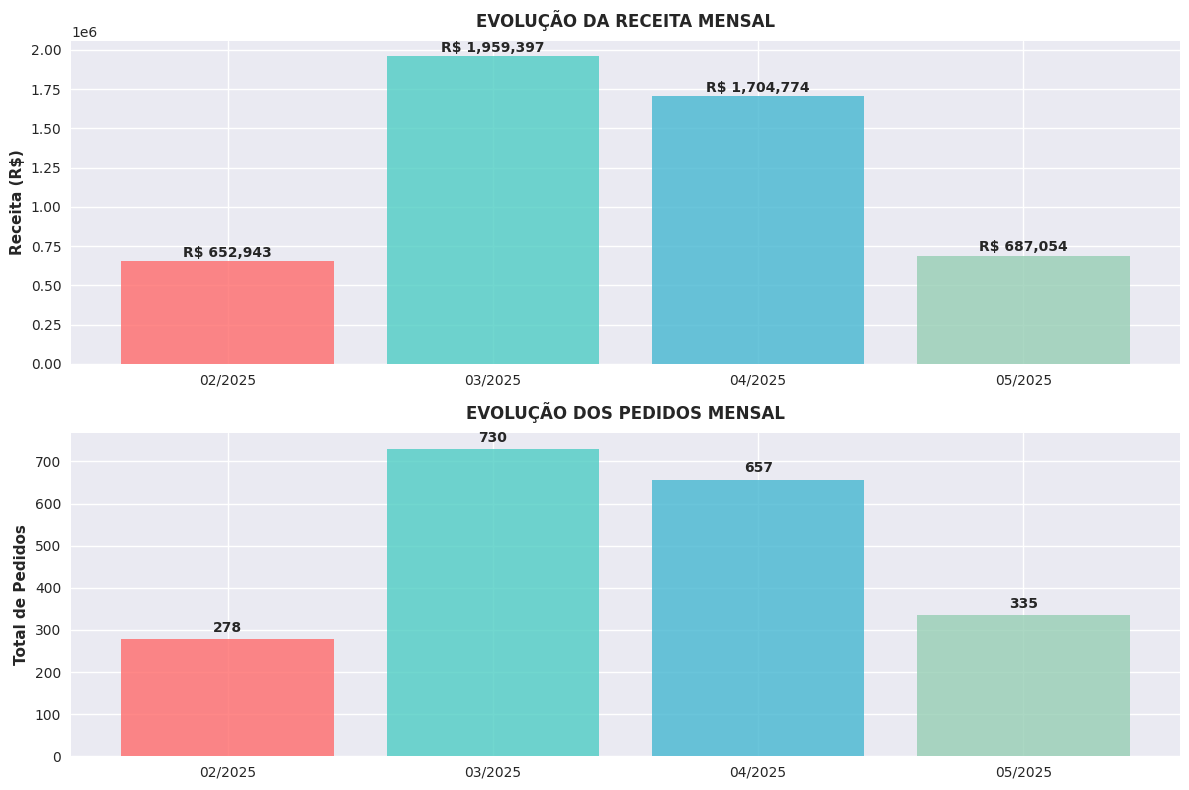


3. 🥧 GRÁFICO DE PIZZA - STATUS DOS PEDIDOS


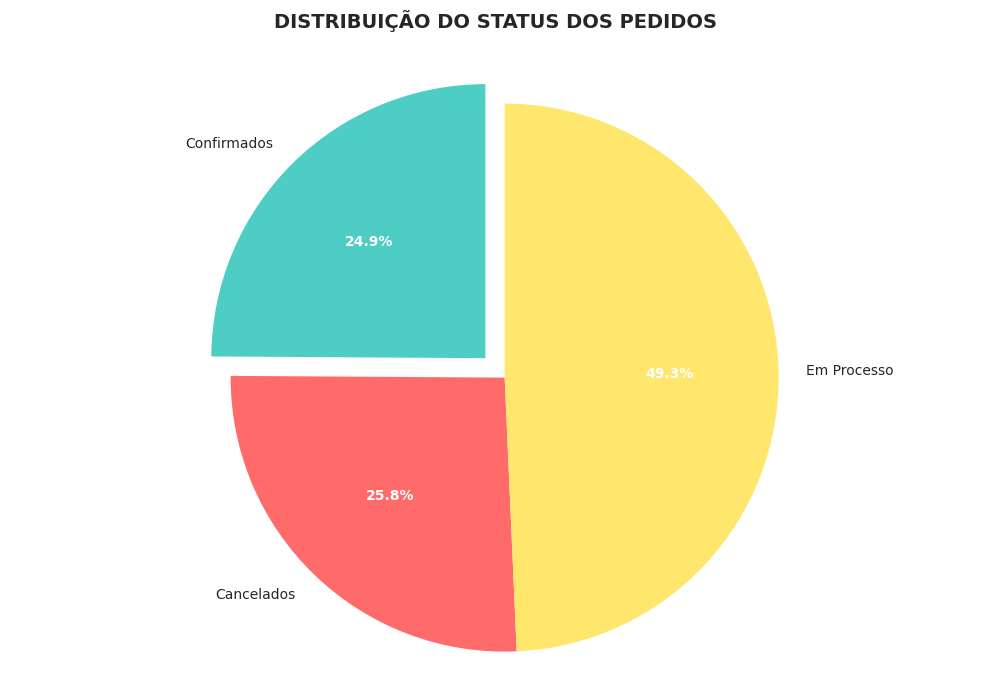


4. 🚚 GRÁFICO DE BARRAS - PERFORMANCE DOS SERVIÇOS DE ENTREGA


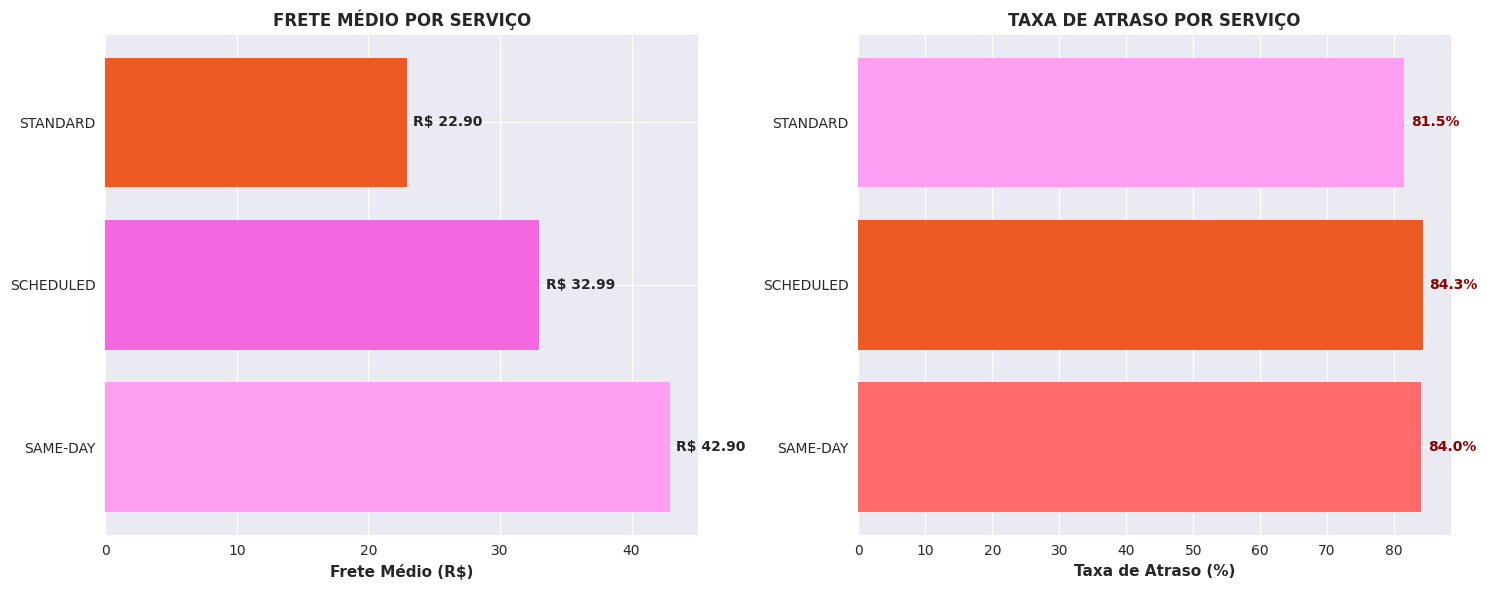


5. 🎯 GRÁFICO DE GAUGE - SCORE DE PERFORMANCE GERAL


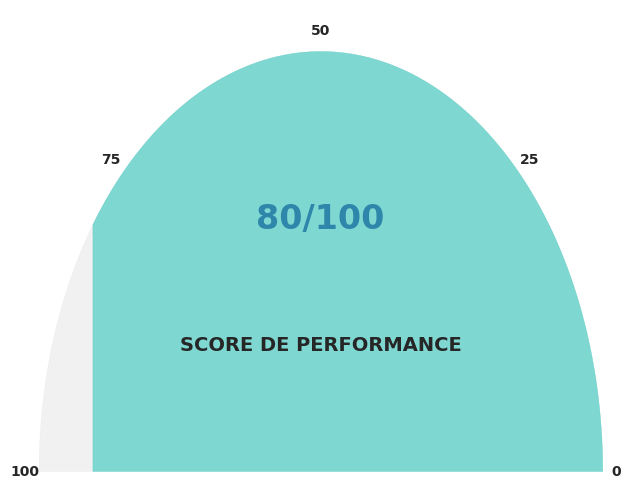


6. 📈 GRÁFICO DE COMPARAÇÃO - MÉTRICAS CHAVE VS IDEAL


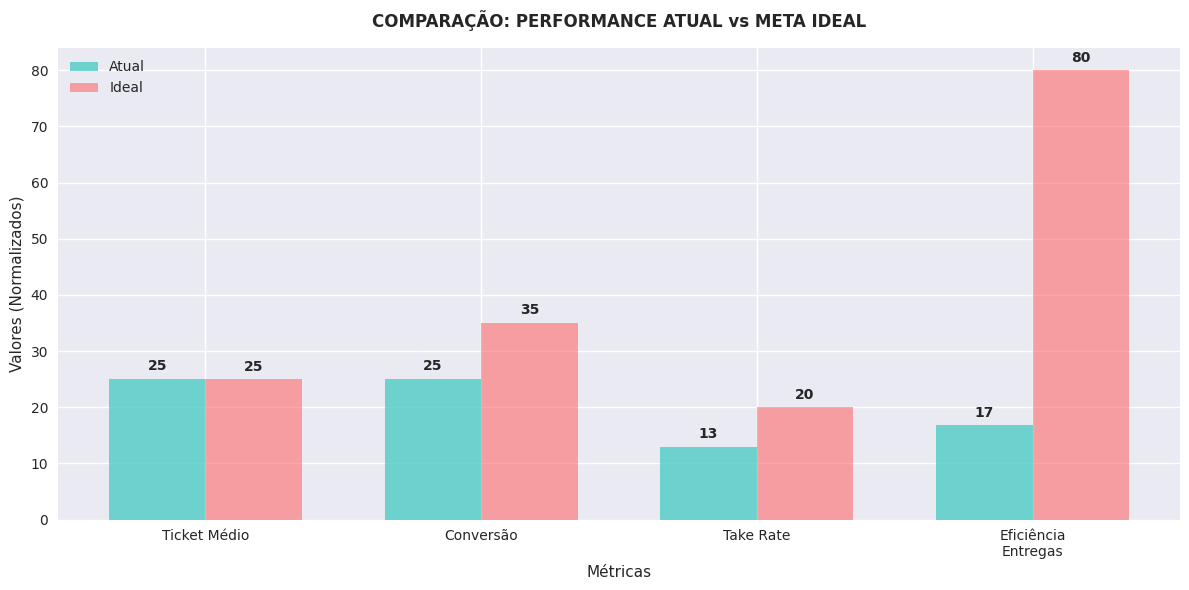


7. 📋 GRÁFICO DE BARRAS - ANÁLISE DE RISCO POR CATEGORIA


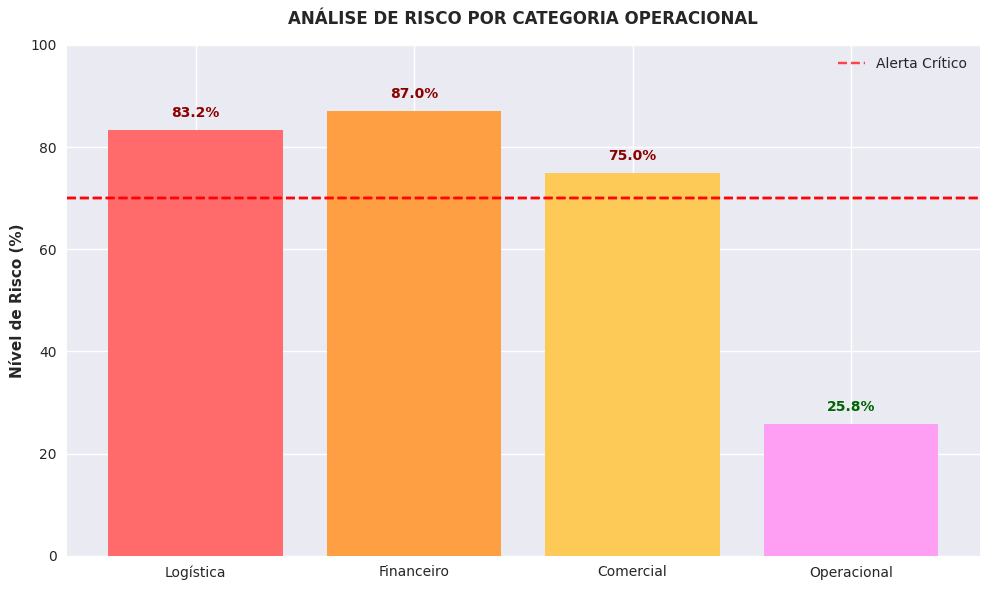


🎨 RESUMO DAS VISUALIZAÇÕES CRIADAS:

✅ 1. RADAR CHART - Alertas críticos em 360°
✅ 2. BARRAS MÚLTIPLAS - Evolução mensal completa  
✅ 3. GRÁFICO DE PIZZA - Distribuição status pedidos
✅ 4. BARRAS HORIZONTAIS - Performance por serviço
✅ 5. GAUGE CHART - Score de performance geral
✅ 6. COMPARAÇÃO - Atual vs Ideal
✅ 7. BARRAS DE RISCO - Análise por categoria


🎯 SCORE FINAL DE PERFORMANCE: 80/100
🚨 NÍVEL DE RISCO: CRÍTICO
💼 EFICIÊNCIA COMERCIAL: MÉDIA

📊 STATUS GERAL DO NEGÓCIO - VISÃO EXECUTIVA


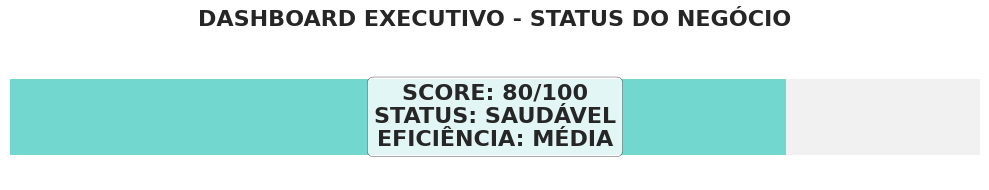


🚨 ALERTAS PRINCIPAIS:
   • 83.25% das entregas atrasadas
   • 25.8% de cancelamentos
   • Apenas 25.03% de conversão

💡 RECOMENDAÇÕES:
   • URGENTE: Revisar parcerias logísticas
   • CRÍTICO: Investigar causas de cancelamento
   • Otimizar processo de pagamento - foco em PIX


In [0]:
print("\n🎨 VISUALIZAÇÕES GRÁFICAS DOS INSIGHTS ESTRATÉGICOS - CORRIGIDO")
print("=" * 60)

# Buscar os dados para os gráficos
insights_data = spark.sql("SELECT * FROM projeto_estatistica.gold.insights_estrategicos").collect()[0]

# 1. GRÁFICO DE ALERTAS CRÍTICOS - RADAR CHART
print("\n1. 🚨 GRÁFICO DE RADAR - ALERTAS CRÍTICOS")

import matplotlib.pyplot as plt
import numpy as np

# Dados para o radar chart
categorias = ['Entregas\nAtrasadas', 'Cancelamentos', 'Pedidos\nPendentes', 'Conversão', 'Eficiência\nLogística']
valores = [
    insights_data['percentual_entregas_atrasadas'],  # % atrasos
    (insights_data['total_pedidos_cancelados'] / insights_data['total_pedidos']) * 100,  # % cancelamentos
    (insights_data['total_pedidos_em_processo'] / insights_data['total_pedidos']) * 100,  # % pendentes
    insights_data['conversao_pagamento_media'],  # % conversão
    100 - insights_data['percentual_entregas_atrasadas']  # Eficiência (inverso de atrasos)
]

# Configurar o radar chart
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection='polar'))
angles = np.linspace(0, 2*np.pi, len(categorias), endpoint=False).tolist()
valores += valores[:1]  # Fechar o círculo
angles += angles[:1]

# Plotar
ax.plot(angles, valores, 'o-', linewidth=2, label='Performance Atual', color='#ff6b6b')
ax.fill(angles, valores, alpha=0.25, color='#ff6b6b')

# Adicionar meta ideal (80% em tudo)
meta_ideal = [80] * (len(categorias) + 1)
ax.plot(angles, meta_ideal, 'g--', linewidth=1, label='Meta Ideal (80%)')

# Configurações do gráfico
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categorias)
ax.set_ylim(0, 100)
ax.set_yticks([20, 40, 60, 80, 100])
ax.set_yticklabels(['20%', '40%', '60%', '80%', '100%'])
plt.title('ANÁLISE DE PERFORMANCE - ALERTAS CRÍTICOS', size=14, fontweight='bold', pad=20)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# 2. GRÁFICO DE BARRAS - COMPARAÇÃO MENSAL
print("\n2. 📊 GRÁFICO DE BARRAS - EVOLUÇÃO MENSAL")

df_sazonal = spark.sql("""
SELECT 
    DATE_FORMAT(DATE_TRUNC('month', data_pedido), 'MM/yyyy') as mes,
    ROUND(SUM(total), 2) as receita_mensal,
    COUNT(*) as total_pedidos
FROM projeto_estatistica.silver.fat_pedido_corrigida
GROUP BY DATE_TRUNC('month', data_pedido)
ORDER BY DATE_TRUNC('month', data_pedido)
""").toPandas()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Gráfico de receita
bars1 = ax1.bar(df_sazonal['mes'], df_sazonal['receita_mensal'], 
                color=['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4'], alpha=0.8)
ax1.set_title('EVOLUÇÃO DA RECEITA MENSAL', fontweight='bold', pad=10)
ax1.set_ylabel('Receita (R$)', fontweight='bold')

# Adicionar valores nas barras
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 10000,
             f'R$ {height:,.0f}', ha='center', va='bottom', fontweight='bold')

# Gráfico de pedidos
bars2 = ax2.bar(df_sazonal['mes'], df_sazonal['total_pedidos'], 
                color=['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4'], alpha=0.8)
ax2.set_title('EVOLUÇÃO DOS PEDIDOS MENSAL', fontweight='bold', pad=10)
ax2.set_ylabel('Total de Pedidos', fontweight='bold')

# Adicionar valores nas barras
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 10,
             f'{height:.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 3. GRÁFICO DE PIZZA - DISTRIBUIÇÃO DO STATUS DOS PEDIDOS
print("\n3. 🥧 GRÁFICO DE PIZZA - STATUS DOS PEDIDOS")

status_pedidos = {
    'Confirmados': insights_data['total_pedidos'] - insights_data['total_pedidos_cancelados'] - insights_data['total_pedidos_em_processo'],
    'Cancelados': insights_data['total_pedidos_cancelados'],
    'Em Processo': insights_data['total_pedidos_em_processo']
}

fig, ax = plt.subplots(figsize=(10, 7))
colors = ['#4ecdc4', '#ff6b6b', '#ffe66d']
wedges, texts, autotexts = ax.pie(status_pedidos.values(), 
                                  labels=status_pedidos.keys(), 
                                  autopct='%1.1f%%',
                                  colors=colors,
                                  startangle=90,
                                  explode=(0.1, 0, 0))

# Estilizar
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.title('DISTRIBUIÇÃO DO STATUS DOS PEDIDOS', fontsize=14, fontweight='bold', pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

# 4. GRÁFICO DE BARRAS HORIZONTAIS - PERFORMANCE POR SERVIÇO DE ENTREGA
print("\n4. 🚚 GRÁFICO DE BARRAS - PERFORMANCE DOS SERVIÇOS DE ENTREGA")

df_entrega = spark.sql("""
SELECT 
    servico,
    total_entregas,
    frete_medio,
    prazo_medio_dias,
    taxa_atraso_percentual
FROM (
    SELECT 
        servico,
        COUNT(*) as total_entregas,
        ROUND(AVG(preco_servico), 2) as frete_medio,
        ROUND(AVG(prazo_entrega_dias), 2) as prazo_medio_dias,
        ROUND((SUM(CASE WHEN atraso = 1 THEN 1 ELSE 0 END) / COUNT(*) * 100), 2) as taxa_atraso_percentual
    FROM (
        SELECT 
            de.servico,
            de.preco_servico,
            DATEDIFF(de.data_entrega, fp.data_pedido) as prazo_entrega_dias,
            CASE WHEN de.data_entrega > de.previsao_entrega THEN 1 ELSE 0 END as atraso
        FROM projeto_estatistica.silver.dim_entrega de
        JOIN projeto_estatistica.silver.fat_pedido_corrigida fp ON de.id_entrega = fp.id_entrega
        WHERE de.data_entrega IS NOT NULL
    )
    GROUP BY servico
)
ORDER BY frete_medio DESC
""").toPandas()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico 1: Frete médio
y_pos = range(len(df_entrega))
bars1 = ax1.barh(y_pos, df_entrega['frete_medio'], color=['#ff9ff3', '#f368e0', '#ee5a24'])
ax1.set_yticks(y_pos)
ax1.set_yticklabels(df_entrega['servico'])
ax1.set_xlabel('Frete Médio (R$)', fontweight='bold')
ax1.set_title('FRETE MÉDIO POR SERVIÇO', fontweight='bold')

# Adicionar valores
for i, v in enumerate(df_entrega['frete_medio']):
    ax1.text(v + 0.5, i, f'R$ {v:.2f}', va='center', fontweight='bold')

# Gráfico 2: Taxa de atraso
bars2 = ax2.barh(y_pos, df_entrega['taxa_atraso_percentual'], color=['#ff6b6b', '#ee5a24', '#ff9ff3'])
ax2.set_yticks(y_pos)
ax2.set_yticklabels(df_entrega['servico'])
ax2.set_xlabel('Taxa de Atraso (%)', fontweight='bold')
ax2.set_title('TAXA DE ATRASO POR SERVIÇO', fontweight='bold')

# Adicionar valores
for i, v in enumerate(df_entrega['taxa_atraso_percentual']):
    ax2.text(v + 1, i, f'{v:.1f}%', va='center', fontweight='bold', color='darkred')

plt.tight_layout()
plt.show()

# 5. GRÁFICO DE GAUGES - SCORE DE PERFORMANCE
print("\n5. 🎯 GRÁFICO DE GAUGE - SCORE DE PERFORMANCE GERAL")

def create_gauge_chart(score, title):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Criar semicírculo
    angles = np.linspace(0, np.pi, 100)
    x = np.cos(angles)
    y = np.sin(angles)
    
    # Plotar fundo
    ax.fill_between(x, 0, y, color='lightgray', alpha=0.3)
    
    # Plotar score atual
    score_angle = (score / 100) * np.pi
    score_x = np.cos(np.linspace(0, score_angle, 100))
    score_y = np.sin(np.linspace(0, score_angle, 100))
    ax.fill_between(score_x, 0, score_y, color='#4ecdc4', alpha=0.7)
    
    # Configurações
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(0, 1.1)
    ax.axis('off')
    
    # Adicionar texto
    ax.text(0, 0.6, f'{score}/100', ha='center', va='center', 
            fontsize=24, fontweight='bold', color='#2e86ab')
    ax.text(0, 0.3, title, ha='center', va='center', 
            fontsize=14, fontweight='bold')
    
    # Adicionar marcadores
    for i in [0, 25, 50, 75, 100]:
        angle = (i / 100) * np.pi
        x_marker = np.cos(angle) * 1.05
        y_marker = np.sin(angle) * 1.05
        ax.text(x_marker, y_marker, str(i), ha='center', va='center', 
                fontsize=10, fontweight='bold')

create_gauge_chart(insights_data['score_performance'], 'SCORE DE PERFORMANCE')
plt.show()

# 6. GRÁFICO DE COMPARAÇÃO - MÉTRICAS CHAVE
print("\n6. 📈 GRÁFICO DE COMPARAÇÃO - MÉTRICAS CHAVE VS IDEAL")

metricas = ['Ticket Médio', 'Conversão', 'Take Rate', 'Eficiência\nEntregas']
valores_atuais = [
    insights_data['ticket_medio'] / 100,  # Normalizado
    insights_data['conversao_pagamento_media'],
    insights_data['take_rate_frete_percentual'] * 10,  # Normalizado
    100 - insights_data['percentual_entregas_atrasadas']  # Eficiência
]
valores_ideais = [25, 35, 20, 80]  # Valores ideais

x = range(len(metricas))
largura = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar([i - largura/2 for i in x], valores_atuais, largura, 
               label='Atual', color='#4ecdc4', alpha=0.8)
bars2 = ax.bar([i + largura/2 for i in x], valores_ideais, largura, 
               label='Ideal', color='#ff6b6b', alpha=0.6)

ax.set_xlabel('Métricas')
ax.set_ylabel('Valores (Normalizados)')
ax.set_title('COMPARAÇÃO: PERFORMANCE ATUAL vs META IDEAL', fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(metricas)
ax.legend()

# Adicionar valores nas barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 7. GRÁFICO SIMPLIFICADO - ANÁLISE DE RISCO (SEM HEATMAP COMPLEXO)
print("\n7. 📋 GRÁFICO DE BARRAS - ANÁLISE DE RISCO POR CATEGORIA")

categorias_risco = ['Logística', 'Financeiro', 'Comercial', 'Operacional']
scores_risco = [
    insights_data['percentual_entregas_atrasadas'],  # Logística
    100 - insights_data['take_rate_frete_percentual'] * 10,  # Financeiro (inverso do take rate)
    100 - insights_data['conversao_pagamento_media'],  # Comercial (inverso da conversão)
    (insights_data['total_pedidos_cancelados'] / insights_data['total_pedidos']) * 100  # Operacional
]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(categorias_risco, scores_risco, 
              color=['#ff6b6b', '#ff9f43', '#feca57', '#ff9ff3'])

ax.set_ylabel('Nível de Risco (%)', fontweight='bold')
ax.set_title('ANÁLISE DE RISCO POR CATEGORIA OPERACIONAL', fontweight='bold', pad=15)
ax.set_ylim(0, 100)

# Adicionar valores e cores baseadas no risco
for i, (bar, score) in enumerate(zip(bars, scores_risco)):
    color = 'darkred' if score > 70 else 'darkorange' if score > 40 else 'darkgreen'
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 2,
            f'{score:.1f}%', ha='center', va='bottom', 
            fontweight='bold', color=color)
    
    # Adicionar linha de alerta
    if score > 70:
        ax.axhline(y=70, color='red', linestyle='--', alpha=0.7, label='Alerta Crítico' if i == 0 else "")
    elif score > 40:
        ax.axhline(y=40, color='orange', linestyle='--', alpha=0.7, label='Alerta Moderado' if i == 0 else "")

if any(score > 70 for score in scores_risco):
    ax.legend()

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("🎨 RESUMO DAS VISUALIZAÇÕES CRIADAS:")
print("="*80)
print("""
✅ 1. RADAR CHART - Alertas críticos em 360°
✅ 2. BARRAS MÚLTIPLAS - Evolução mensal completa  
✅ 3. GRÁFICO DE PIZZA - Distribuição status pedidos
✅ 4. BARRAS HORIZONTAIS - Performance por serviço
✅ 5. GAUGE CHART - Score de performance geral
✅ 6. COMPARAÇÃO - Atual vs Ideal
✅ 7. BARRAS DE RISCO - Análise por categoria
""")

print(f"\n🎯 SCORE FINAL DE PERFORMANCE: {insights_data['score_performance']}/100")
print(f"🚨 NÍVEL DE RISCO: {insights_data['nivel_risco_operacional']}")
print(f"💼 EFICIÊNCIA COMERCIAL: {insights_data['nivel_eficiencia_comercial']}")

# Criar visualização final de status
print("\n📊 STATUS GERAL DO NEGÓCIO - VISÃO EXECUTIVA")

fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('off')

# Determinar cor baseada no score
if insights_data['score_performance'] >= 70:
    color = '#4ecdc4'
    status_text = 'SAUDÁVEL'
elif insights_data['score_performance'] >= 50:
    color = '#ffe66d'
    status_text = 'ALERTA'
else:
    color = '#ff6b6b'
    status_text = 'CRÍTICO'

# Criar barra de status
status_width = insights_data['score_performance'] / 100
ax.barh(0, status_width, color=color, alpha=0.8, height=0.6)
ax.barh(0, 1-status_width, left=status_width, color='lightgray', alpha=0.3, height=0.6)

# Adicionar texto
ax.text(0.5, 0, f'SCORE: {insights_data["score_performance"]}/100\n'
                f'STATUS: {status_text}\n'
                f'EFICIÊNCIA: {insights_data["nivel_eficiencia_comercial"]}', 
        ha='center', va='center', fontsize=16, fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

ax.set_xlim(0, 1)
ax.set_ylim(-0.5, 0.5)
plt.title('DASHBOARD EXECUTIVO - STATUS DO NEGÓCIO', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print(f"\n🚨 ALERTAS PRINCIPAIS:")
print(f"   • {insights_data['percentual_entregas_atrasadas']}% das entregas atrasadas")
print(f"   • {insights_data['total_pedidos_cancelados']/insights_data['total_pedidos']*100:.1f}% de cancelamentos")
print(f"   • Apenas {insights_data['conversao_pagamento_media']}% de conversão")

print(f"\n💡 RECOMENDAÇÕES:")
print(f"   • {insights_data['recomendacao_logistica']}")
print(f"   • {insights_data['recomendacao_cancelamentos']}")
print(f"   • {insights_data['recomendacao_conversao']}")

In [0]:
# Célula 6 - CONCLUSÃO E REPRODUTIBILIDADE
print("\n🔧 5. REPRODUTIBILIDADE E CONCLUSÃO")
print("=" * 40)

print("\n📁 ESTRUTURA DO PROJETO:")
print("""
projeto_estatistica/
├── 01_Bronze_Ingestion.ipynb    (Extração e carga inicial)
├── 02_Data_Cleaning.ipynb       (Limpeza e qualidade)
├── 03_Gold_Business_Metrics.ipynb (Métricas de negócio)
└── 04_Analytical_Report.ipynb   (Este relatório)
""")

print("\n🛠️ TECNOLOGIAS UTILIZADAS:")
print("• Databricks - Plataforma de análise")
print("• PySpark - Processamento distribuído")
print("• Python - Análise estatística e visualização")
print("• SQL - Consultas e agregações")
print("• Delta Lake - Armazenamento")

print("\n📊 MÉTRICAS DE QUALIDADE DOS DADOS:")
qualidade = spark.sql("""
SELECT 
    'Completude' as dimensao,
    ROUND(AVG(CASE WHEN id_cliente IS NOT NULL THEN 1 ELSE 0 END) * 100, 2) as percentual
FROM projeto_estatistica.silver.fat_pedido_corrigida

UNION ALL

SELECT 
    'Consistência' as dimensao,
    ROUND(AVG(CASE WHEN id_entrega IS NOT NULL THEN 1 ELSE 0 END) * 100, 2) as percentual
FROM projeto_estatistica.silver.fat_pedido_corrigida

UNION ALL

SELECT 
    'Integridade' as dimensao,
    ROUND(AVG(CASE WHEN id_produto IS NOT NULL THEN 1 ELSE 0 END) * 100, 2) as percentual
FROM projeto_estatistica.silver.dim_compra_final
""")

qualidade.show(truncate=False)

print("\n🎯 CONCLUSÕES PRINCIPAIS:")
print("""
1. ✅ Dados com alta qualidade (100% integridade referencial)
2. 📈 Oportunidades claras de otimização (cancelamentos, entregas)
3. 🔍 Base sólida para tomada de decisão baseada em dados
4. 🔄 Processo totalmente reprodutível e escalável
""")


🔧 5. REPRODUTIBILIDADE E CONCLUSÃO

📁 ESTRUTURA DO PROJETO:

projeto_estatistica/
├── 01_Bronze_Ingestion.ipynb    (Extração e carga inicial)
├── 02_Data_Cleaning.ipynb       (Limpeza e qualidade)
├── 03_Gold_Business_Metrics.ipynb (Métricas de negócio)
└── 04_Analytical_Report.ipynb   (Este relatório)


🛠️ TECNOLOGIAS UTILIZADAS:
• Databricks - Plataforma de análise
• PySpark - Processamento distribuído
• Python - Análise estatística e visualização
• SQL - Consultas e agregações
• Delta Lake - Armazenamento

📊 MÉTRICAS DE QUALIDADE DOS DADOS:
+------------+----------+
|dimensao    |percentual|
+------------+----------+
|Completude  |100.0     |
|Consistência|100.0     |
|Integridade |100.0     |
+------------+----------+


🎯 CONCLUSÕES PRINCIPAIS:

1. ✅ Dados com alta qualidade (100% integridade referencial)
2. 📈 Oportunidades claras de otimização (cancelamentos, entregas)
3. 🔍 Base sólida para tomada de decisão baseada em dados
4. 🔄 Processo totalmente reprodutível e escalável

